# Jadu Analysis - EDA

The aim of this notebook is:

1.- Deep dive analysis on Jadu creators use patterns regarding LLMs for all source of tasks such image, video and audio generation to uncover hidden findings and learning.

2.- Help the author of this notebook on his onboarding tasks of getting a better understanding of the company idiosyncrasy

In [99]:
import sys
from pathlib import Path
import pandas as pd
from src.mongo.mongo_db_client import get_collection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

# Softer, high-contrast palette (Tableau-like, no purple bias)
palette = [
    "#4E79A7",  # blue
    "#F28E2B",  # orange
    "#E15759",  # red
    "#76B7B2",  # teal
    "#59A14F",  # green
    "#EDC948",  # yellow
    "#B07AA1",  # muted violet
    "#FF9DA7",  # pink
    "#9C755F",  # brown
    "#BAB0AC",  # gray
]

palette_soft = [
    # Blue ramp
    "#9bc4f5",  # light blue
    "#4b92de",  # base blue
    # "#1f5fae",  # dark blue


    # Orange/Yellow ramp
    "#f6c16b",  # light orange
    "#e08b2d",  # base orange


    # Green ramp
    "#a8d8a3",  # light green
    "#58a65c",  # base green

    # Orange/Yellow ramp
    "#f6c16b",  # light orange
    "#e08b2d",  # base orange

    # Red ramp
    "#f6a6a1",  # light red
    "#e05b5b",  # base red
    "#b23b3b",  # dark red
]

## Load data

In [100]:
DB_NAME = 'renderboard'
COLLECTION_NAME = 'assetGenJobs'
COLLECTION = get_collection(DB_NAME, COLLECTION_NAME)
# Load dataframe from MongoDB collection
df = pd.json_normalize(COLLECTION.find(
        {},
    )
)


In [101]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 45765 entries, 0 to 45764
Columns: 109 entries, _id to modelConfig.modelMetaData.googleGeminiModelId
dtypes: datetime64[us](3), float64(8), int64(1), object(26), str(71)
memory usage: 38.1+ MB


In [102]:
list_columns = list(df.columns)
for col in list_columns:
    print(col)

_id
jobId
userId
createdAt
status
updatedAt
modelConfig.name
modelConfig.id
modelConfig.outputType
modelConfig.modelType
modelConfig.provider
modelConfig.pollingIntervalMs
modelConfig.noOfGenerations
modelConfig.inputs
outputLinks.cancel
outputLinks.poll
outputLinks.stream
outputLinks.result
modelConfig.modelTitle
jobMetaData.traits
jobMetaData.artStyle
jobMetaData.characterName
error.code
error.message
error.details.timestamp
jobMetaData.controlNetConfigId
modelConfig.modelMetaData.replicatePredictionURL
jobMetaData.destinationModelName
error.details.modelId
modelMetaData.traits
modelMetaData.artStyle
modelMetaData.characterName
assetId
modelConfig.modelMetaData.waitForCompletion
jobFeedback.isLiked
jobMetaData.triggerWord
jobMetaData.b2ZipUrl
modelConfig.modelMetaData.viduPredictionURL
jobMetaData.jobBatchId
modelConfig.modelLabels
modelConfig.costConfig.defaultCost
modelConfig.costConfig.rules
outputLinks.result.version
outputLinks.result.weights
jobMetaData.gender
modelConfig.model

In [103]:
### COLUMNS OF INTEREST (based on the above list and some manual inspection of the data):
# modelConfig.costConfig.defaultCost --> Cost of the job  
# modelConfig.costConfig.rules	--> Not sure, but seems to be a JSON with the cost breakdown of the job (e.g. compute time, storage, etc.) [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
# qualityAnalysis.score	--> Overall quality score (0-10)
# qualityAnalysis.reasoning --> Explanation of the quality score (25000+ unique values, very long text in some cases). Is it LLM-generated? Seems to be, as some entries are very similar except for the numbers (e.g. "The quality score is 7 because the generated image has good composition and color balance, but the details are somewhat lacking." vs "The quality score is 3 because the generated video has poor resolution and noticeable artifacts throughout.")
# qualityAnalysis.transformedScore	--> Unclear but transformation of the original scoring
# qualityAnalysis.rewrittenPrompt	--> Rewritten prompt to improve quality 
# resultDownloadedAt --> Proxy for quality !! If users download the result, it means they liked it. We can use this as a binary proxy for quality and see how it correlates with the qualityAnalysis.score and the cost of the job. We can also analyze the reasoning to see if there are common themes in high vs low quality jobs.

## Columns of interest
Based on the column list + manual inspection.

### Cost & pricing
- `modelConfig.costConfig.defaultCost` — Default cost of the job.
- `modelConfig.costConfig.rules` — Pricing rules by condition (likely a JSON list, e.g. duration → cost).  
  Example: `[{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, ...]`

### Quality signals
- `qualityAnalysis.score` — Overall quality score (0–10).
- `qualityAnalysis.reasoning` — Long-form explanation for the score (25k+ unique values).  
  Likely LLM-generated: many entries are structurally similar with different numbers.
- `qualityAnalysis.transformedScore` — Derived/normalized version of the original score (needs validation).
- `qualityAnalysis.rewrittenPrompt` — Prompt rewritten to improve quality.

### Behavioral proxy
- `resultDownloadedAt` — Proxy for user satisfaction.  
  If a user downloads the result, we can treat it as a positive outcome and compare it against:
  - `qualityAnalysis.score`
  - `modelConfig.costConfig.defaultCost`
  - recurring themes in `qualityAnalysis.reasoning`


- `jobMetaData.*` --> All the columns are empty ('jobMetaData.storyId','jobMetaData.sceneId','jobMetaData.isSketchToShotImage'...)



## Feature enginnering

In [104]:
# Date transformations 

df['dt'] = pd.to_datetime(df['createdAt']).dt.strftime('%Y-%m-%d')
# Also the isoweek and isoyear might be useful for time series analysis
df_isocal = pd.to_datetime(df['createdAt']).dt.isocalendar()
df['isoyear'] = df_isocal['year']   
# Isoweek date such as 2024-W27 is not very useful, let's convert it to a number such as 202427
df['isoweek'] = df_isocal.apply(lambda x: f"{x['year']}{x['week']:02d}", axis=1)

In [105]:
# Narrow down to the most common model types based on id and name
def classify_model_type(model_id, model_name):
    if 't2i' in model_id or 'Text to Image' in model_name:
        return 't2i'
    elif 'i2i' in model_id or 'Image to Image' in model_name:
        return 'i2i'
    elif 'i2v' in model_id or 'Image to Video' in model_name:
        return 'i2v'
    elif 'v2v' in model_id or 'Video to Video' in model_name:
        return 'v2v'
    elif 't2v' in model_id or 'Text to Video' in model_name:
        return 't2v'
    elif 't2s' in model_id or 'Text to Speech' in model_name:
        return 't2s'
    elif 's2v' in model_id or 'Speech to Video' in model_name:
        return 's2v'
    elif 'Minimatics' in model_name:
        return 'minimatics'
    elif 'Character Models' in model_name:
        return 'character_models'
    elif 'Sound Effects' in model_name:
        return 'sound_effects'
    else:
        return 'unknown'
df['model_type'] = df.apply(lambda row: classify_model_type(row['modelConfig.id'], row['modelConfig.name']), axis=1)

#### Job type

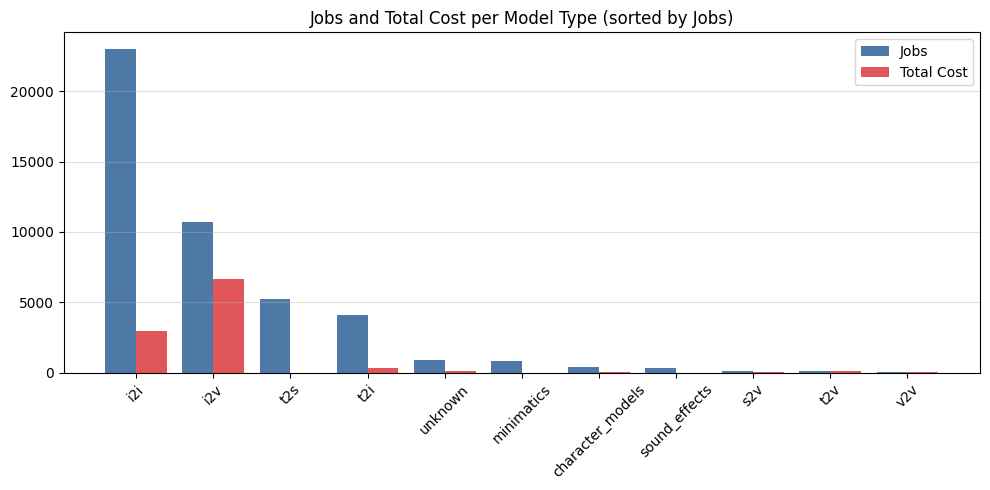

In [234]:
df["modelConfig.costConfig.defaultCost"] = pd.to_numeric(
    df["modelConfig.costConfig.defaultCost"], errors="coerce"
)

counts = df["model_type"].value_counts()
order = counts.index  # already descending
total_cost = df.groupby("model_type")["modelConfig.costConfig.defaultCost"].sum()
total_cost = total_cost.reindex(order)

x = np.arange(len(order))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, counts.values, width, label="Jobs", color="#4E79A7")
ax.bar(x + width/2, total_cost.values, width, label="Total Cost", color="#E15759")

ax.set_xticks(x)
ax.set_xticklabels(order, rotation=45)
ax.set_title("Jobs and Total Cost per Model Type (sorted by Jobs)")
ax.grid(alpha=0.4, axis="y")
ax.legend()

plt.tight_layout()
plt.show()


In [107]:
df_ts_type_raw = df.groupby(['isoweek','model_type']).size().unstack().fillna(0)
df_ts_type_raw_dist = 100*df_ts_type_raw.div(df_ts_type_raw.sum(axis=1), axis=0)
round(df_ts_type_raw_dist.tail(),1)

model_type  character_models   i2i   i2v  minimatics  s2v  sound_effects  \
isoweek                                                                    
202604                   0.0  52.2  27.7         0.8  0.1            0.0   
202605                   0.0  39.9   5.7         3.2  0.4            0.8   
202606                   0.0  80.1  10.2         2.7  0.0            0.0   
202607                   0.0  31.6  36.9         1.9  2.4            0.0   
202608                   0.0  58.0  14.5         0.0  0.0            0.0   

model_type   t2i   t2s  t2v  unknown  v2v  
isoweek                                    
202604       3.2  15.0  0.0      1.0  0.0  
202605       6.8  42.1  0.6      0.5  0.0  
202606       6.6   0.3  0.0      0.1  0.0  
202607       7.4  18.3  0.2      1.2  0.0  
202608      18.9   8.2  0.0      0.5  0.0

In [108]:
# Aggregated model type to just show the main categories
df['model_type_agg'] = df['model_type'].apply(lambda x: x if x in ['t2i', 'i2i', 'i2v', 'v2v', 't2v'] else 'other')

In [109]:
df_ts_type = df.groupby(['isoweek','model_type_agg']).size().unstack().fillna(0)
df_ts_type_dist = 100*df_ts_type.div(df_ts_type.sum(axis=1), axis=0)
round(df_ts_type_dist.tail(),1)

model_type_agg   i2i   i2v  other   t2i  t2v  v2v
isoweek                                          
202604          52.2  27.7   17.0   3.2  0.0  0.0
202605          39.9   5.7   47.1   6.8  0.6  0.0
202606          80.1  10.2    3.1   6.6  0.0  0.0
202607          31.6  36.9   23.9   7.4  0.2  0.0
202608          58.0  14.5    8.6  18.9  0.0  0.0

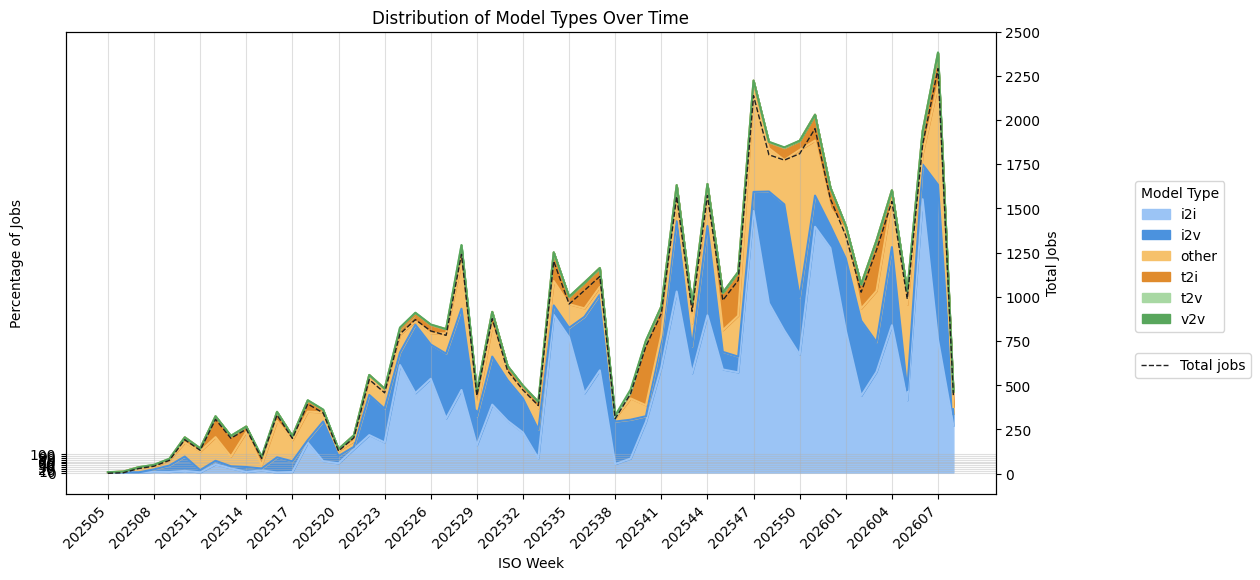

In [235]:
fig, ax = plt.subplots(figsize=(12, 6))

# area chart (percent)
#df_ts_type_dist.plot(kind='area', ax=ax, stacked=True, color=palette[:df_ts_type_dist.shape[1]])
df_ts_type.plot(kind='area', ax=ax, stacked=True, color=palette_soft[:df_ts_type_dist.shape[1]])
#df_ts_type_dist.plot(kind='area', ax=ax, stacked=True, color=palette_soft[:df_ts_type_dist.shape[1]])

ax.set_title('Distribution of Model Types Over Time')
ax.set_xlabel('ISO Week')
ax.set_ylabel('Percentage of Jobs')
ax.set_yticks(range(0, 101, 10))
ax.legend(title='Model Type', loc=(1.15, 0.35))
ax.grid(alpha=0.4)


step = 3  # 1=every week, 2=every 2 weeks, etc.
x = np.arange(len(df_ts_type_dist.index))

ax.set_xticks(x[::step])
ax.set_xticklabels(df_ts_type_dist.index[::step].astype(str), rotation=45, ha="right")

# secondary axis (absolute totals)
ax2 = ax.twinx()
total_jobs = df_ts_type.sum(axis=1)
ax2.plot(total_jobs.index, total_jobs.values, color="#222222", linewidth=1.0, linestyle='--', label='Total jobs')
ax2.set_ylabel('Total Jobs')

# 250-step ticks
ymax = total_jobs.max()
ax2.set_yticks(range(0, int(ymax) + 251, 250))

ax2.legend(loc=(1.15, 0.25))

plt.show()


In [236]:
df_ts_type_cost = df.groupby(['isoweek','model_type_agg'])['modelConfig.costConfig.defaultCost'].sum().unstack().fillna(0)
df_ts_type_dist_cost = 100*df_ts_type_cost.div(df_ts_type_cost.sum(axis=1), axis=0)
round(df_ts_type_dist_cost.tail(),1)

model_type_agg   i2i   i2v  other  t2i  t2v  v2v
isoweek                                         
202604          31.6  65.5    1.2  1.7  0.0  0.0
202605          53.5  29.8    4.3  8.7  3.7  0.0
202606          63.8  33.3    0.2  2.7  0.0  0.0
202607          17.3  74.6    5.6  1.8  0.7  0.0
202608          42.7  50.4    0.0  6.9  0.0  0.0

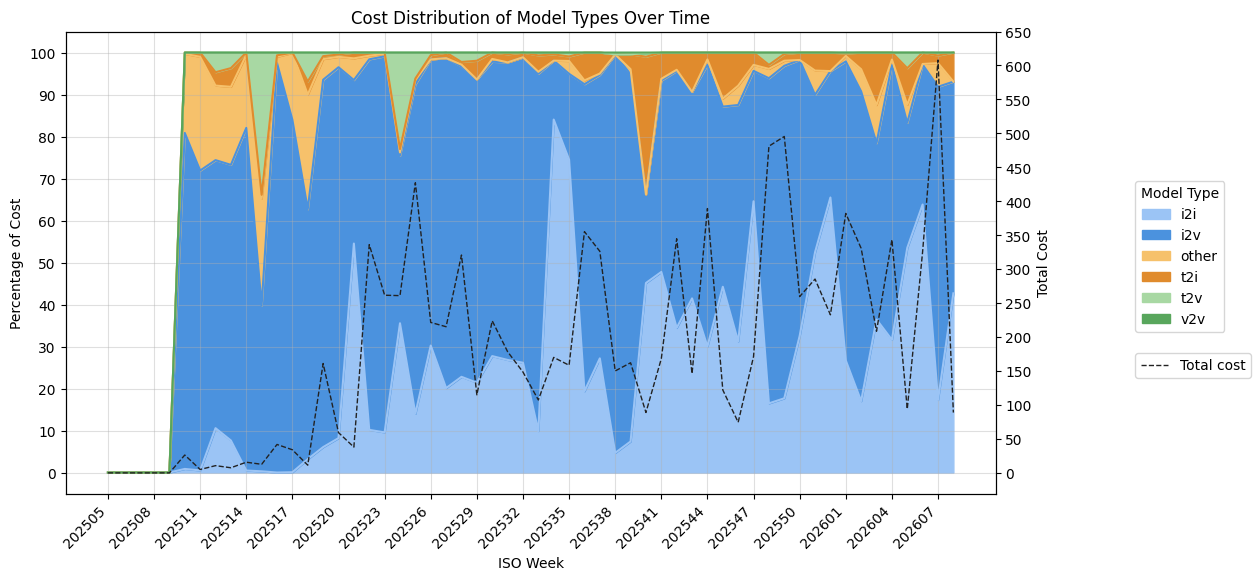

In [238]:
fig, ax = plt.subplots(figsize=(12, 6))

# area chart (percent)
#df_ts_type_cost.plot(kind='area', ax=ax, stacked=True, color=palette_soft[:df_ts_type_dist_cost.shape[1]])
df_ts_type_dist_cost.plot(kind='area', ax=ax, stacked=True, color=palette_soft[:df_ts_type_dist_cost.shape[1]])
ax.set_title('Cost Distribution of Model Types Over Time')
ax.set_xlabel('ISO Week')
ax.set_ylabel('Percentage of Cost')
ax.set_yticks(range(0, 101, 10))
ax.legend(title='Model Type', loc=(1.15, 0.35))
ax.grid(alpha=0.4)


step = 3  # 1=every week, 2=every 2 weeks, etc.
x = np.arange(len(df_ts_type_dist_cost.index))

ax.set_xticks(x[::step])
ax.set_xticklabels(df_ts_type_dist_cost.index[::step].astype(str), rotation=45, ha="right")

# secondary axis (absolute totals)
ax2 = ax.twinx()
total_cost = df_ts_type_cost.sum(axis=1)
ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=1.0, linestyle='--', label='Total cost')
ax2.set_ylabel('Total Cost')

# 250-step ticks
ymax = total_cost.max()
ax2.set_yticks(range(0, int(ymax) + 51, 50))

ax2.legend(loc=(1.15, 0.25))

plt.show()


## Models over time

In [115]:
# Purpose:
# - Standardize the "model title" used for analysis across providers and model types.
# - Some model types (e.g. t2s) store the model choice inside modelConfig.inputs.
# - Some providers (e.g. Replicate) prefix the model id with the model_type, which we strip.

def _extract_from_inputs(inputs):
    """
    Extract model choice from modelConfig.inputs.
    Supports:
    - dict: {"tts_model": "eleven_v3", ...}
    - list of dicts: [{"id": "tts_model", "value": "eleven_v3", ...}, ...]
    """
    if isinstance(inputs, dict):
        # Prefer explicit tts_model key when present
        for k, v in inputs.items():
            if str(k).lower() == "tts_model":
                return v
        # Otherwise, any key containing "model"
        for k, v in inputs.items():
            if "model" in str(k).lower():
                return v

    elif isinstance(inputs, list):
        # List of UI-like field dicts
        for item in inputs:
            if str(item.get("id", "")).lower() == "tts_model":
                return item.get("value") or item.get("defaultValue")
        for item in inputs:
            if "model" in str(item.get("id", "")).lower():
                return item.get("value") or item.get("defaultValue")

    return None


def normalize_id(model_id, model_type):
    """
    Replicate model ids often include a redundant prefix, e.g. "i2i-gpt-image-1".
    Strip the "{model_type}-" prefix so it matches OpenAI naming ("gpt-image-1").
    """
    if not model_id:
        return None
    model_id = str(model_id)
    prefix = f"{model_type}-"
    return model_id[len(prefix):] if model_id.startswith(prefix) else model_id


def extract_model_title(row):
    """
    Rules:
    - t2s: model is stored in modelConfig.inputs (use _extract_from_inputs)
    - i2i + OPENAI: use modelConfig.modelMetaData.openAIModelId
    - i2i + REPLICATE: normalize modelConfig.id to match OpenAI naming
    - otherwise: fallback to modelConfig.modelTitle
    """
    model_type = row.get("model_type")
    provider = str(row.get("modelConfig.provider", "")).upper()

    if model_type == "t2s":
        return _extract_from_inputs(row.get("modelConfig.inputs")) or "unknown_t2s_model"

    if model_type == "i2i":
        if provider == "OPENAI":
            return row.get("modelConfig.modelMetaData.openAIModelId") or "unknown_openai_model"
        if provider == "REPLICATE":
            model_id = row.get("modelConfig.id")
            return normalize_id(model_id, model_type) or "unknown_model"
    
    if  model_type == "t2i":
        if provider == "OPENAI" or provider == "REPLICATE":
            model_id = row.get("modelConfig.id")
            return normalize_id(model_id, model_type) or "unknown_model"


    return row.get("modelConfig.modelTitle")


df["model_title_extracted"] = df.apply(extract_model_title, axis=1)


In [116]:
#df[['model_type','model_title_extracted']].sample(15)

In [117]:
#df[(df['model_type']=='t2i') & (df['model_title_extracted'].str.contains('Image', case=False, na=False))].sample(3).T

In [118]:
#df.loc[[4795,17213,11420]][['model_type','model_title_extracted','modelConfig.modelTitle','modelConfig.inputs']].T

In [119]:
# modelConfig.modelMetaData.openAIModelId	, (gpt-image-1)
# modelConfig.id	(i2i-gpt-image-1)

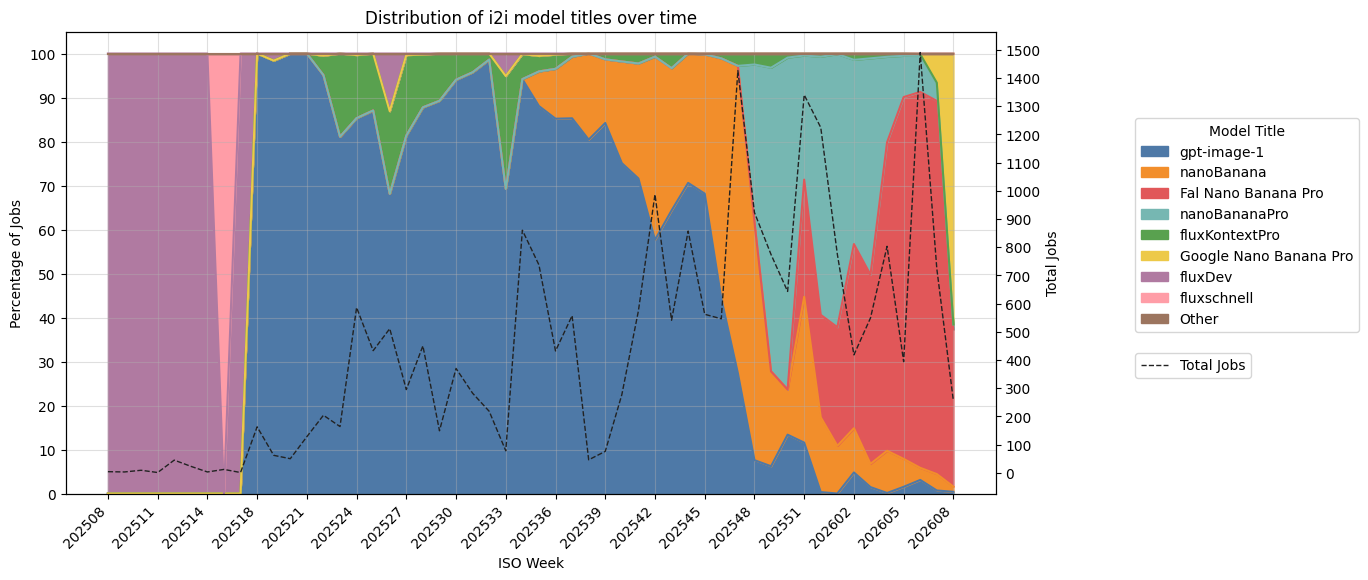

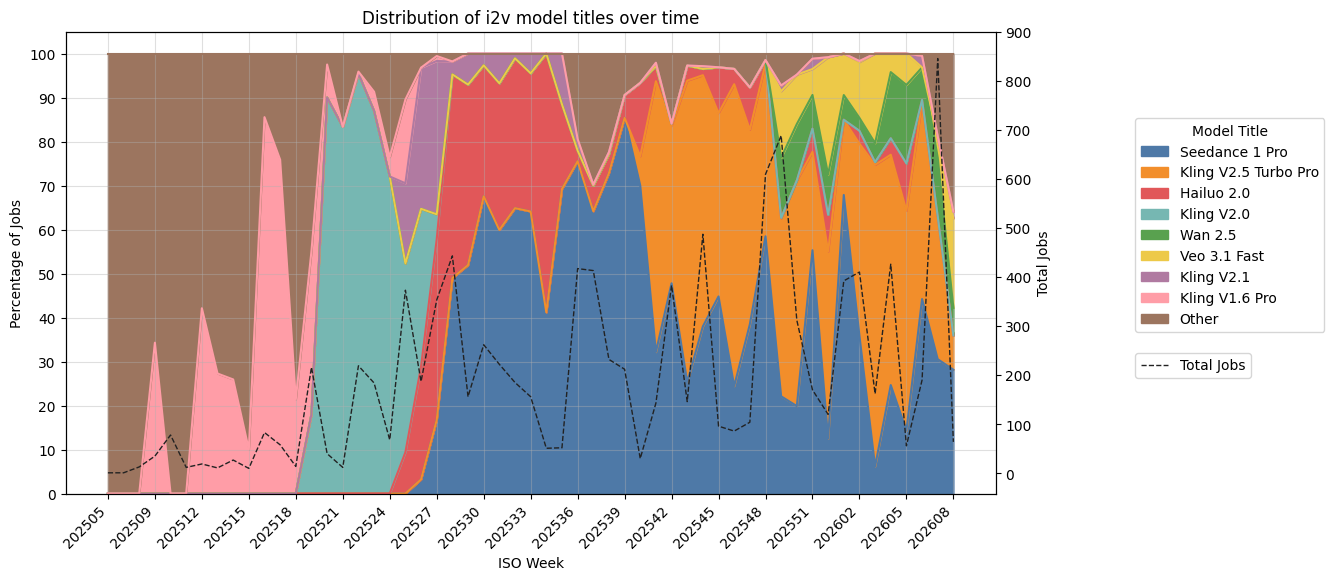

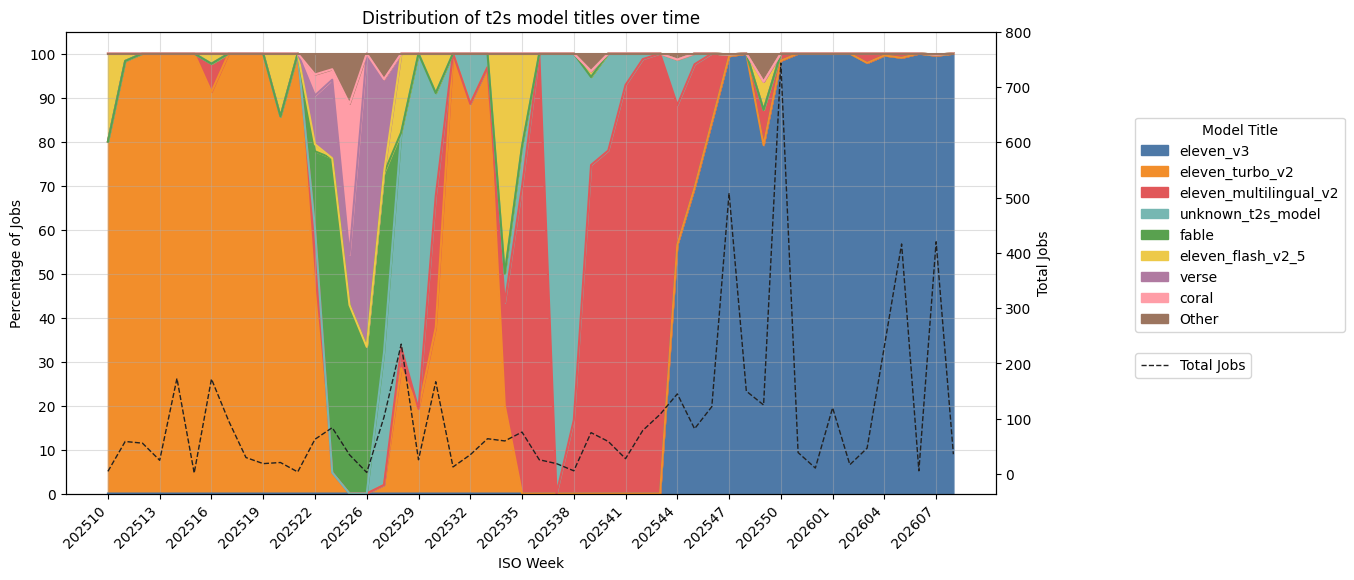

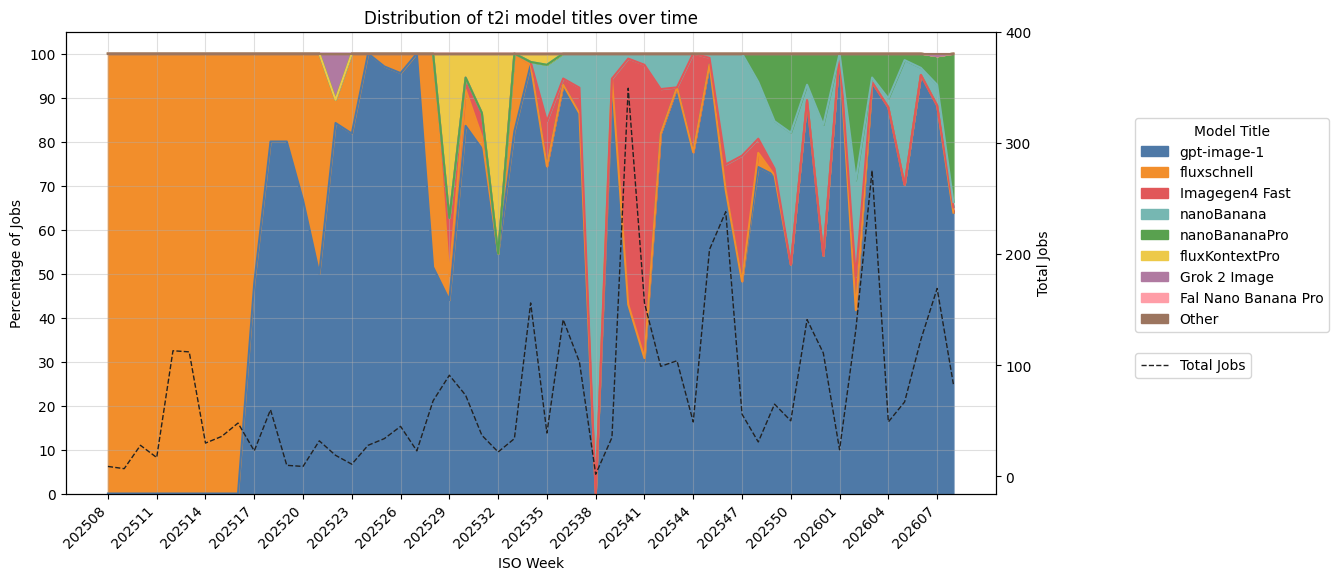

In [120]:
list_model_types = df['model_type'].value_counts().index.tolist() 
#for model_type in list_model_types:
for model_type in ['i2i','i2v','t2s','t2i']:
    # Let's make a cool visualization of the most common model titles for each model type per week
    df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'model_title_extracted']).size().unstack().fillna(0)
    #df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
    # Let's make a smart agregation of the model titles to just show the main ones and group the rest into "other"
    top_n = 8
    top_titles = df_type_week.sum().nlargest(top_n).index
    df_type_week['Other'] = df_type_week.drop(columns=top_titles).sum(axis=1)
    df_type_week = df_type_week[top_titles.tolist() + ['Other']]
    # normalize by row  
    df_type_week_dist = 100*df_type_week.div(df_type_week.sum(axis=1), axis=0)
    round(df_type_week_dist.tail(),1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # area chart (percent)
    df_type_week_dist.plot(kind='area', ax=ax, stacked=True, color=palette[:df_type_week_dist.shape[1]])
    ax.set_title(f'Distribution of {model_type} model titles over time')
    ax.set_xlabel('ISO Week')
    ax.set_ylabel('Percentage of Jobs')
    ax.set_yticks(range(0, 101, 10))
    ax.legend(title='Model Title', loc=(1.15, 0.35))
    ax.grid(alpha=0.4)


    step = 3  # 1=every week, 2=every 2 weeks, etc.
    x = np.arange(len(df_type_week_dist.index))

    ax.set_xticks(x[::step])
    ax.set_xticklabels(df_type_week_dist.index[::step].astype(str), rotation=45, ha="right")

    # secondary axis (absolute totals)
    ax2 = ax.twinx()
    total_cost = df_type_week.sum(axis=1)
    ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=1.0, linestyle='--', label='Total Jobs')
    ax2.set_ylabel('Total Jobs')

    # 250-step ticks
    ymax = total_cost.max()
    ax2.set_yticks(range(0, int(ymax) + 100, 100))

    ax2.legend(loc=(1.15, 0.25))

    plt.show()


In [121]:
import re

import colorsys
from matplotlib.colors import to_rgb

# 1) Define model families (tune these rules as you discover variants)
FAMILY_RULES = [
    ("nanobanana", r"nano\s*banana|nanobanan|nano-banana"),
    ("gpt-image", r"gpt[-_ ]?image[-_ ]?1|gptimage"),
    ("flux", r"flux"),
    ("imagen", r"imagen"),
    ("seedance", r"seedance"),
    ("kling", r"kling"),
    ("runway", r"runway"),
    ("veo", r"veo"),
    ("elevenlabs", r"eleven"),
]

FAMILY_BASE_COLORS = {
    "nanobanana": "#4E79A7",  # blue
    "gpt-image": "#F28E2B",   # orange
    "flux": "#59A14F",        # green
    "imagen": "#E15759",      # red
    "seedance": "#76B7B2",    # teal
    "kling": "#EDC948",       # yellow
    "runway": "#B07AA1",      # violet
    "veo": "#FF9DA7",        # pink
    "elevenlabs": "#E15759", # "#9C755F",  # brown
    "other": "#BAB0AC",       # gray
}


def darker_ramp(base_hex, n, min_light=0.28, max_light=0.58):
    """
    Create n shades from dark → mid, avoiding washed-out light tones.
    """
    h, l, s = colorsys.rgb_to_hls(*to_rgb(base_hex))
    # Clamp lightness range so we stay saturated
    low = max(min_light, l * 0.6)
    high = min(max_light, l * 1.0)
    return [colorsys.hls_to_rgb(h, li, s) for li in np.linspace(low, high, n)]


def detect_family(title):
    if not title:
        return "other"
    s = str(title).lower()
    for fam, pattern in FAMILY_RULES:
        if re.search(pattern, s):
            return fam
    return "other"



def ramp_around_base(base_hex, n, light_shift=0.22, dark_shift=0.18):
    """
    Builds a light -> base -> dark ramp.
    The base color is forced into the ramp (closest slot).
    """
    if n <= 1:
        return [to_rgb(base_hex)]

    h, l, s = colorsys.rgb_to_hls(*to_rgb(base_hex))

    l_light = min(l + light_shift, 0.85)
    l_dark = max(l - dark_shift, 0.15)

    levels = np.linspace(l_light, l_dark, n)

    # force the closest level to the base lightness
    idx = int(np.argmin(np.abs(levels - l)))
    levels[idx] = l

    return [colorsys.hls_to_rgb(h, li, s) for li in levels]


def build_family_palette(titles, totals=None):
    family_map = {}
    for t in titles:
        family_map.setdefault(detect_family(t), []).append(t)

    palette = {}
    for fam, items in family_map.items():
        base = FAMILY_BASE_COLORS.get(fam, FAMILY_BASE_COLORS["other"])

        # optional: most common gets darker/base
        if totals is not None:
            items = sorted(items, key=lambda x: totals.get(x, 0), reverse=True)
        else:
            items = sorted(items)

        shades = ramp_around_base(base, len(items))
        for t, c in zip(items, shades):
            palette[t] = c
    return palette

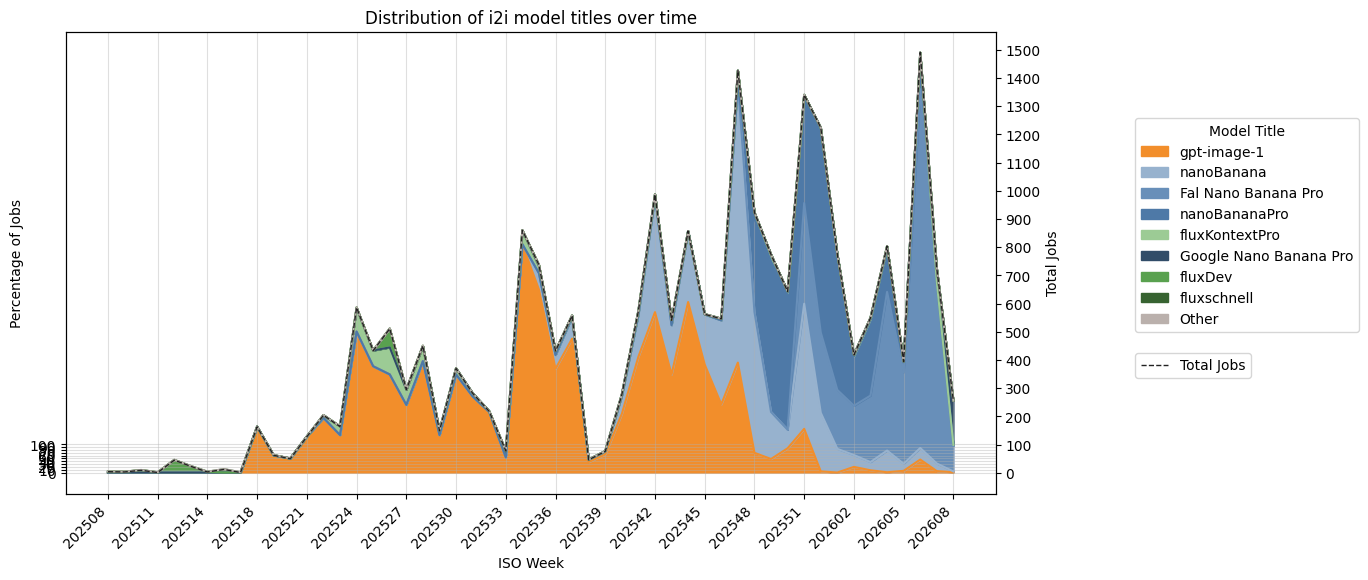

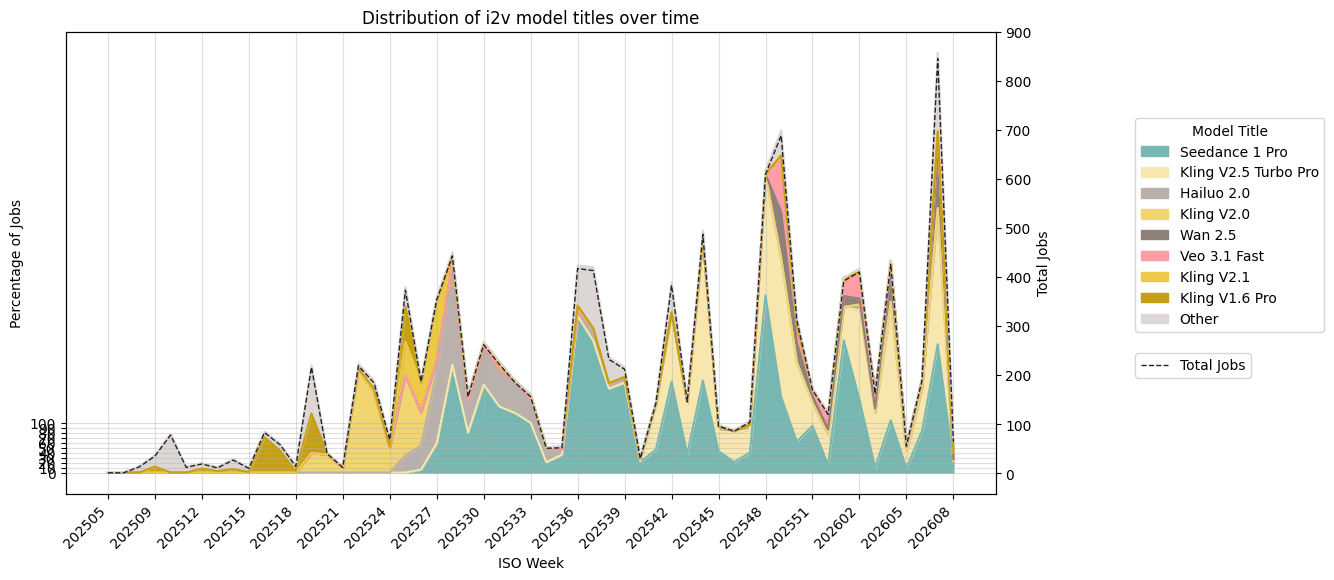

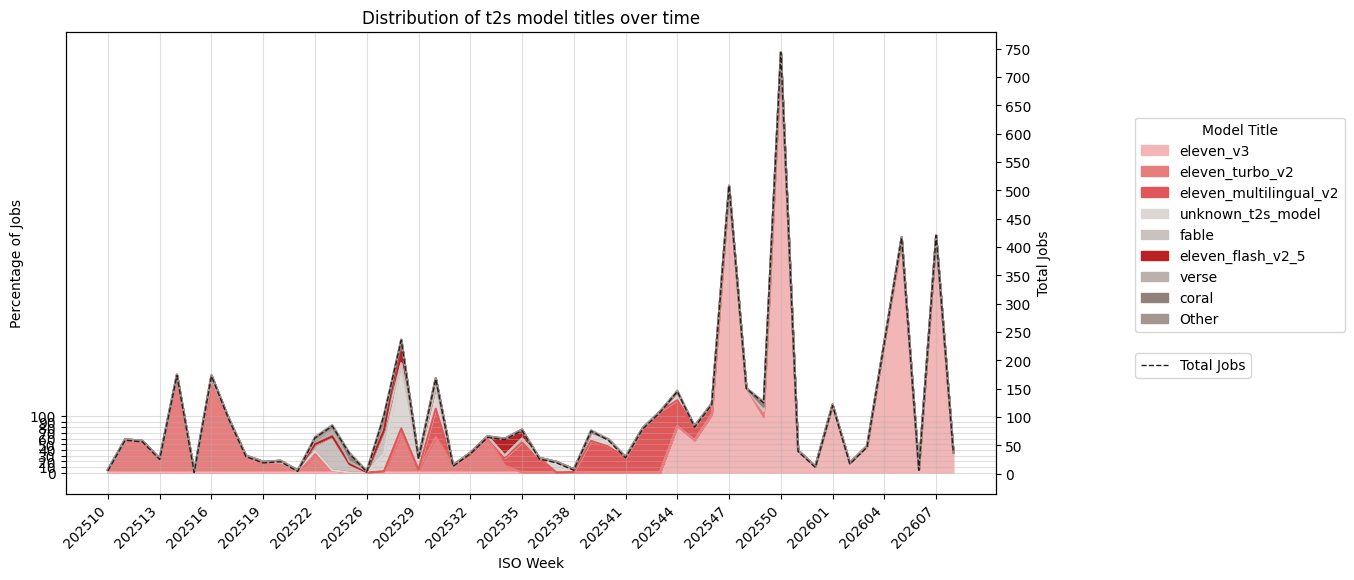

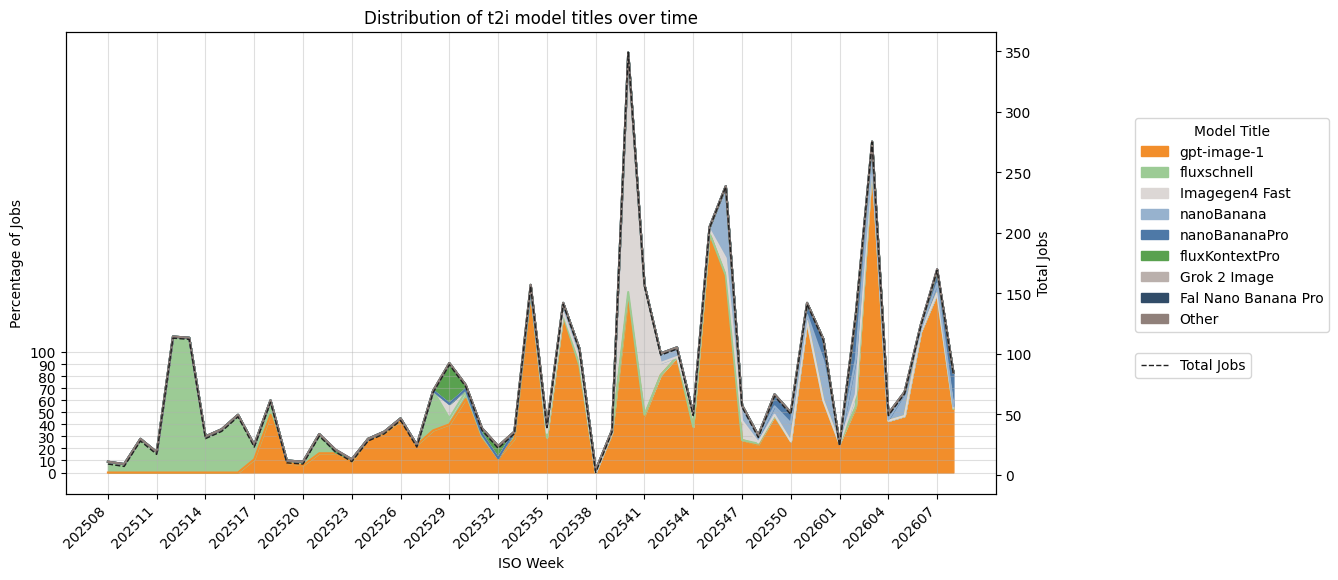

In [ ]:
list_model_types = df['model_type'].value_counts().index.tolist() 
#for model_type in list_model_types:
for model_type in ['i2i','i2v','t2s','t2i']:
    # Let's make a cool visualization of the most common model titles for each model type per week
    df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'model_title_extracted']).size().unstack().fillna(0)
    #df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
    # Let's make a smart agregation of the model titles to just show the main ones and group the rest into "other"
    top_n = 8
    top_titles = df_type_week.sum().nlargest(top_n).index
    df_type_week['Other'] = df_type_week.drop(columns=top_titles).sum(axis=1)
    df_type_week = df_type_week[top_titles.tolist() + ['Other']]
    # normalize by row  
    df_type_week_dist = 100*df_type_week.div(df_type_week.sum(axis=1), axis=0)
    #df_type_week_dist = df_type_week.copy()
    round(df_type_week_dist.tail(),1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # area chart (percent)
    totals = df_type_week.sum().to_dict()
    palette_map = build_family_palette(df_type_week_dist.columns, totals=totals)


    df_type_week_dist.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[palette_map[c] for c in df_type_week_dist.columns]
    )
    ax.set_title(f'Distribution of {model_type} model titles over time')
    ax.set_xlabel('ISO Week')
    ax.set_ylabel('Percentage of Jobs')
    ax.set_yticks(range(0, 101, 10))
    ax.legend(title='Model Title', loc=(1.15, 0.35))
    ax.grid(alpha=0.4)


    step = 3  # 1=every week, 2=every 2 weeks, etc.
    x = np.arange(len(df_type_week_dist.index))

    ax.set_xticks(x[::step])
    ax.set_xticklabels(df_type_week_dist.index[::step].astype(str), rotation=45, ha="right")

    # secondary axis (absolute totals)
    ax2 = ax.twinx()
    total_cost = df_type_week.sum(axis=1)
    ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=1.0, linestyle='--', label='Total Jobs')
    ax2.set_ylabel('Total Jobs')

    # 250-step ticks
    ymax = total_cost.max()
    if ymax >= 800:
        ax2.set_yticks(range(0, int(ymax) + 100, 100))
    elif ymax >= 200:
        ax2.set_yticks(range(0, int(ymax) + 50, 50))
    else:
        ax2.set_yticks(range(0, int(ymax) + 10, 10))

    ax2.legend(loc=(1.15, 0.25))

    plt.show()


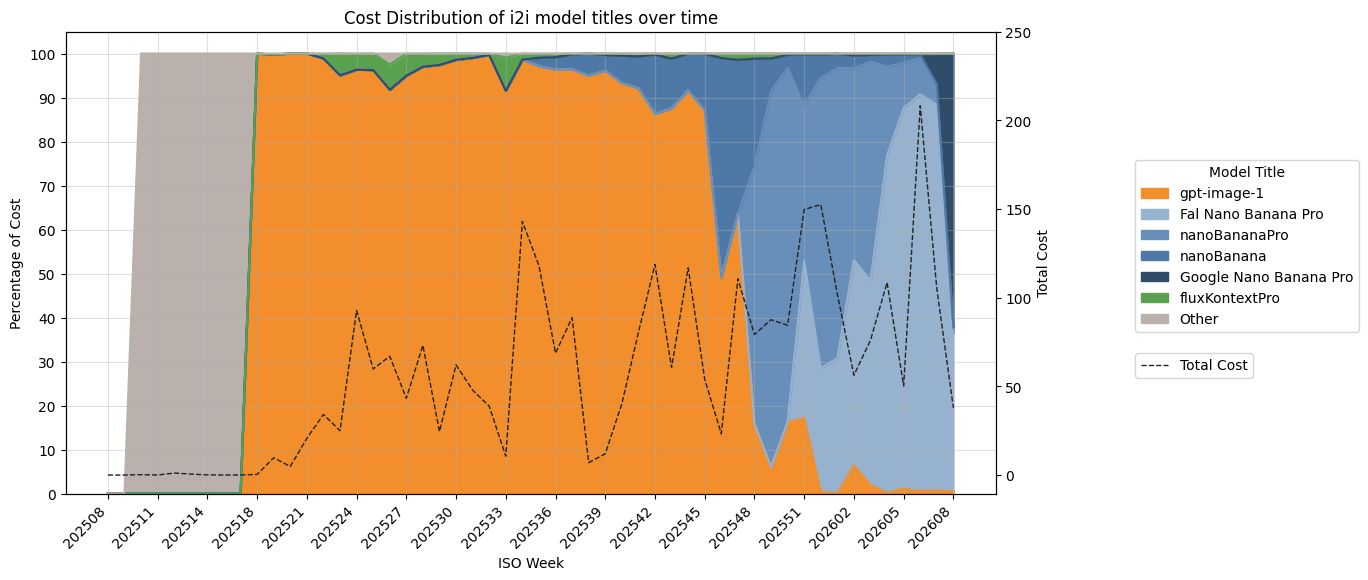

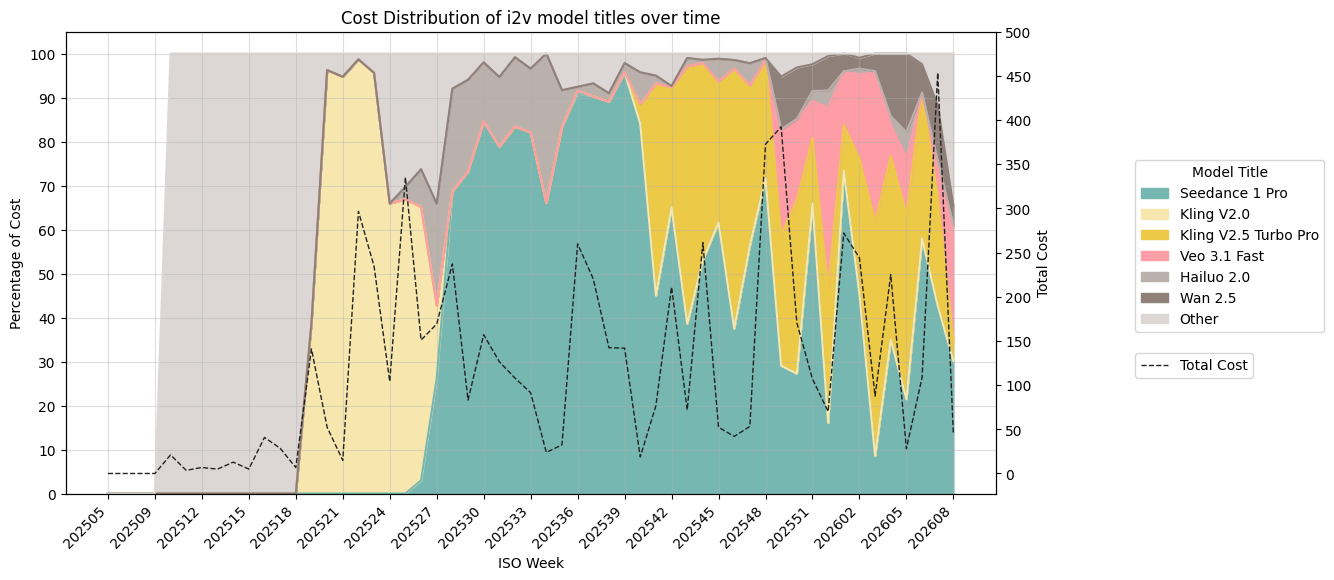

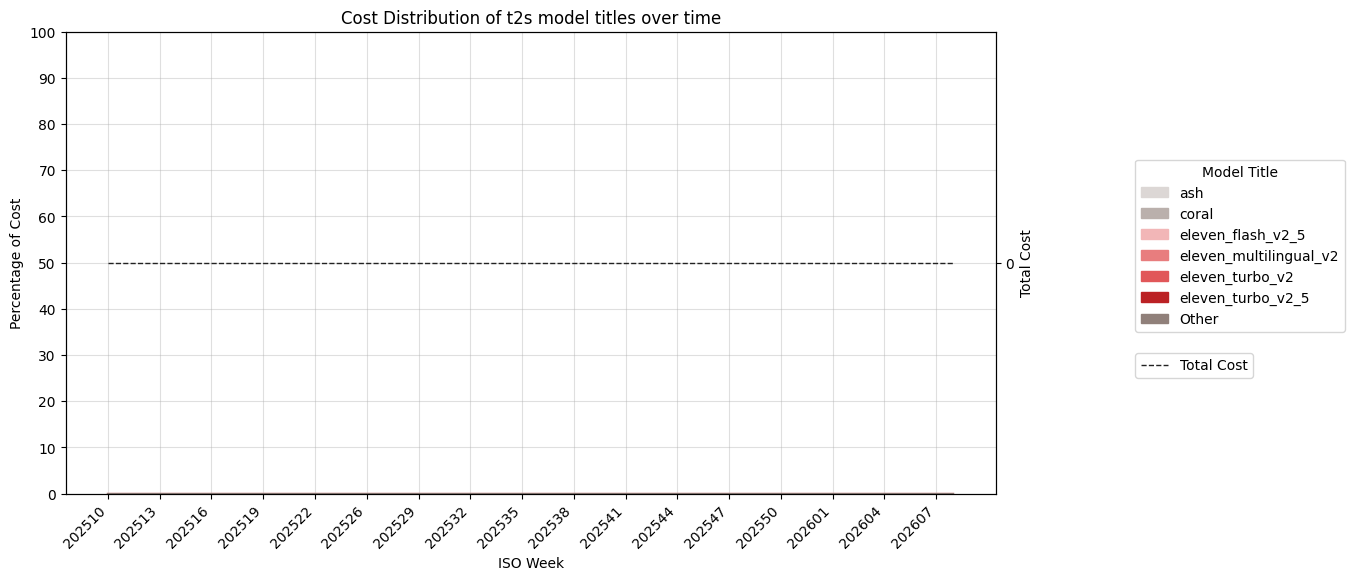

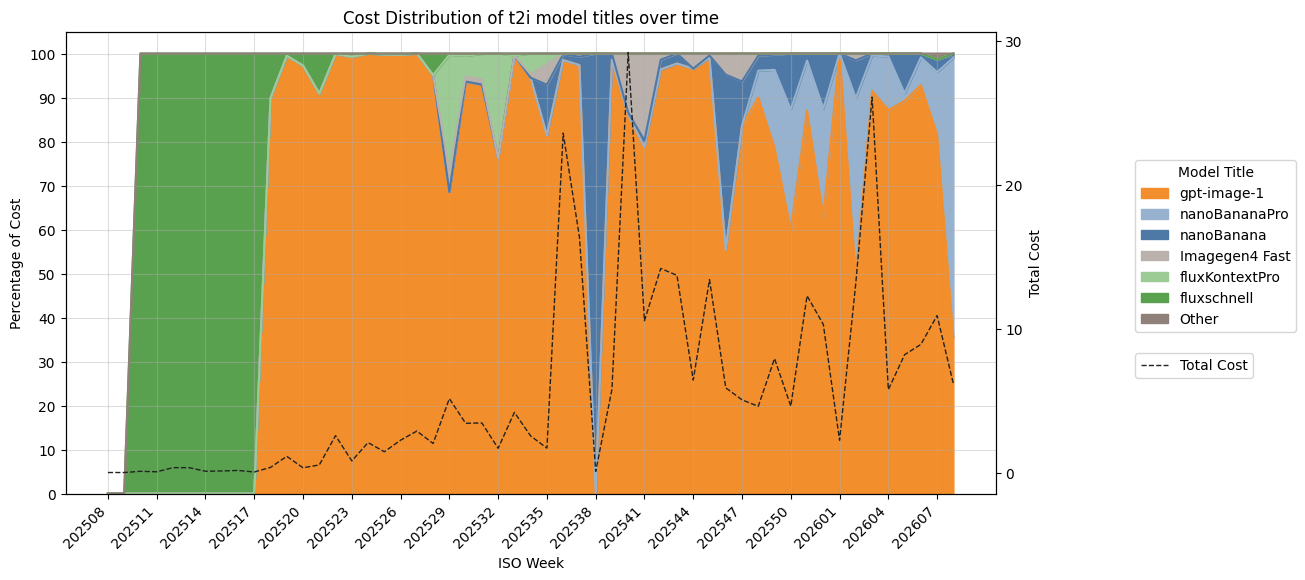

In [123]:
for model_type in ['i2i','i2v','t2s','t2i']:
    # Let's make a cool visualization of the total cost for each model type per week
    df_type_week = df[df['model_type'] == model_type].groupby(['isoweek','model_title_extracted'])[['modelConfig.costConfig.defaultCost']].sum().unstack().fillna(0)['modelConfig.costConfig.defaultCost']
    #df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
    # Let's make a smart agregation of the model titles to just show the main ones and group the rest into "other"
    top_n = 6
    top_titles = df_type_week.sum().nlargest(top_n).index
    df_type_week['Other'] = df_type_week.drop(columns=top_titles).sum(axis=1)
    df_type_week = df_type_week[top_titles.tolist() + ['Other']]
    # normalize by row  
    df_type_week_dist = 100*df_type_week.div(df_type_week.sum(axis=1), axis=0)
    round(df_type_week_dist.tail(),1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # area chart (percent)
    totals = df_type_week.sum().to_dict()
    palette_map = build_family_palette(df_type_week_dist.columns, totals=totals)


    df_type_week_dist.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[palette_map[c] for c in df_type_week_dist.columns]
    )
    ax.set_title(f'Cost Distribution of {model_type} model titles over time')
    ax.set_xlabel('ISO Week')
    ax.set_ylabel('Percentage of Cost')
    ax.set_yticks(range(0, 101, 10))
    ax.legend(title='Model Title', loc=(1.15, 0.35))
    ax.grid(alpha=0.4)


    step = 3  # 1=every week, 2=every 2 weeks, etc.
    x = np.arange(len(df_type_week_dist.index))

    ax.set_xticks(x[::step])
    ax.set_xticklabels(df_type_week_dist.index[::step].astype(str), rotation=45, ha="right")

    # secondary axis (absolute totals)
    ax2 = ax.twinx()
    total_cost = df_type_week.sum(axis=1)
    ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=1.0, linestyle='--', label='Total Cost')
    ax2.set_ylabel('Total Cost')

    # 250-step ticks
    ymax = total_cost.max()
    if ymax >= 800:
        ax2.set_yticks(range(0, int(ymax) + 100, 100))
    elif ymax >= 200:
        ax2.set_yticks(range(0, int(ymax) + 50, 50))
    else:
        ax2.set_yticks(range(0, int(ymax) + 10, 10))

    ax2.legend(loc=(1.15, 0.25))

    plt.show()


# Quality

In [ ]:
### COLUMNS OF INTEREST (based on the above list and some manual inspection of the data):
# modelConfig.costConfig.defaultCost --> Cost of the job  
# modelConfig.costConfig.rules	--> Not sure, but seems to be a JSON with the cost breakdown of the job (e.g. compute time, storage, etc.) [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
# qualityAnalysis.score	--> Overall quality score (0-10)
# qualityAnalysis.reasoning --> Explanation of the quality score (25000+ unique values, very long text in some cases). Is it LLM-generated? Seems to be, as some entries are very similar except for the numbers (e.g. "The quality score is 7 because the generated image has good composition and color balance, but the details are somewhat lacking." vs "The quality score is 3 because the generated video has poor resolution and noticeable artifacts throughout.")
# qualityAnalysis.transformedScore	--> Unclear but transformation of the original scoring
# qualityAnalysis.rewrittenPrompt	--> Rewritten prompt to improve quality 
# resultDownloadedAt --> Proxy for quality !! If users download the result, it means they liked it. We can use this as a binary proxy for quality and see how it correlates with the qualityAnalysis.score and the cost of the job. We can also analyze the reasoning to see if there are common themes in high vs low quality jobs.

The intend of this section of the notebook is to perform some EDA on the logs files that were provided in order to better understand the data and extract some insights from it. The aim is to indentify patterns, anomalies, or trends that could be useful for further analysis or decision-making and feature engineering for modeling.

Based on model_type (i2i, i2v, t2v...) and model_title_extracted (gpt-image-1, nanobananpro..) behaviours such as :

- Cost of generation (ModelConfig.costConfig.defaultCost)
- Quality of the output. Could it be infered from qualityAnalysis.score, resultDownloadedAt ?


##### Basic statistics

In [169]:
def compute_basic_statistics(df: pd.DataFrame) -> pd.DataFrame:
    stats = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Numeric features: compute all statistics
            stats[col] = {
                "mean": df[col].mean(),
                "median": df[col].median(),
                "std_dev": df[col].std(),
                "min": df[col].min(),
                "max": df[col].max(),
                "missing_values": df[col].isna().sum(),
                "unique_values": df[col].nunique(),
            }
        else:
            # Categorical features: compute counts and distribution
            try:
                value_counts = df[col].value_counts()
                unique_count = df[col].nunique()
                most_freq = value_counts.index[0] if len(value_counts) > 0 else None
                most_freq_count = value_counts.iloc[0] if len(value_counts) > 0 else None
            except TypeError:
                # Handle unhashable types (lists, dicts, etc.)
                value_counts = None
                unique_count = "N/A (unhashable type)"
                most_freq = "N/A (unhashable type)"
                most_freq_count = None
            
            stats[col] = {
                "mean": None,
                "median": None,
                "std_dev": None,
                "min": None,
                "max": None,
                "missing_values": df[col].isna().sum(),
                "unique_values": unique_count,
                "most_frequent": most_freq,
                "most_frequent_count": most_freq_count,
            }
    return pd.DataFrame(stats).T

In [171]:
columns_for_analysis = ['modelConfig.costConfig.defaultCost', 'qualityAnalysis.score', 'qualityAnalysis.transformedScore', 'qualityAnalysis.rewrittenPrompt','resultDownloadedAt']
compute_basic_statistics(df[columns_for_analysis])

mean median   std_dev    min   max  \
modelConfig.costConfig.defaultCost  0.269401   0.18  0.308493  0.003   6.0   
qualityAnalysis.score               7.338088    8.0   2.11553    0.0  10.0   
qualityAnalysis.transformedScore         NaN    NaN       NaN    NaN   NaN   
qualityAnalysis.rewrittenPrompt         None   None      None   None  None   
resultDownloadedAt                      None   None      None   None  None   

                                   missing_values unique_values  \
modelConfig.costConfig.defaultCost         7886.0          31.0   
qualityAnalysis.score                     20946.0          11.0   
qualityAnalysis.transformedScore          20946.0           5.0   
qualityAnalysis.rewrittenPrompt             28295         17470   
resultDownloadedAt                          40382          5383   

                                                                        most_frequent  \
modelConfig.costConfig.defaultCost                                                NaN   
qualityAnalysis.score                                                             NaN   
qualityAnalysis.transformedScore                                                  3.0   
qualityAnalysis.rewrittenPrompt     Transform the scene to show the unnamed charac...   
resultDownloadedAt                                         2025-11-06 15:44:01.026000   

                                   most_frequent_count  
modelConfig.costConfig.defaultCost                 NaN  
qualityAnalysis.score                              NaN  
qualityAnalysis.transformedScore               10570.0  
qualityAnalysis.rewrittenPrompt                      1  
resultDownloadedAt                                   1

Hmmm interestingly qualityAnalysis.score seems to have a lot of missing values as well as resultDownloadedAt.

In [200]:
df_cost_mt = df.groupby('model_type')['modelConfig.costConfig.defaultCost'].describe().sort_values(by='count', ascending=False)
df_cost_mt

count      mean           std    min    25%    50%    75%  \
model_type                                                                      
i2i               22594.0  0.130840  5.741855e-02  0.003  0.040  0.150  0.180   
i2v               10684.0  0.619014  3.161620e-01  0.110  0.420  0.500  0.750   
t2i                3643.0  0.083674  7.650757e-02  0.003  0.020  0.039  0.180   
character_models    365.0  0.025000  0.000000e+00  0.025  0.025  0.025  0.025   
unknown             334.0  0.403536  1.662381e-01  0.040  0.490  0.490  0.490   
s2v                 129.0  0.390698  8.333091e-02  0.100  0.400  0.400  0.400   
t2v                  99.0  1.355556  2.064429e+00  0.180  0.270  0.500  0.750   
v2v                  31.0  0.050000  1.410719e-17  0.050  0.050  0.050  0.050   
minimatics            0.0       NaN           NaN    NaN    NaN    NaN    NaN   
sound_effects         0.0       NaN           NaN    NaN    NaN    NaN    NaN   
t2s                   0.0       NaN           NaN    NaN    NaN    NaN    NaN   

                    max  
model_type               
i2i               0.180  
i2v               2.500  
t2i               0.180  
character_models  0.025  
unknown           0.500  
s2v               1.000  
t2v               6.000  
v2v               0.050  
minimatics          NaN  
sound_effects       NaN  
t2s                 NaN

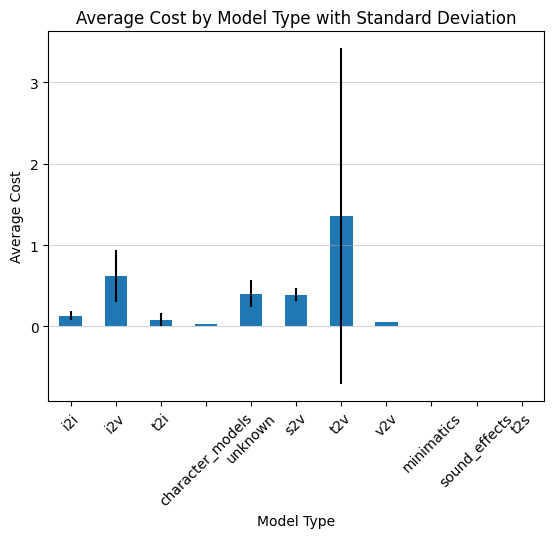

In [214]:
df_cost_mt.plot(kind='bar', y='mean', yerr='std', legend=False)
plt.title('Average Cost by Model Type with Standard Deviation')
plt.xlabel('Model Type')
plt.ylabel('Average Cost')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

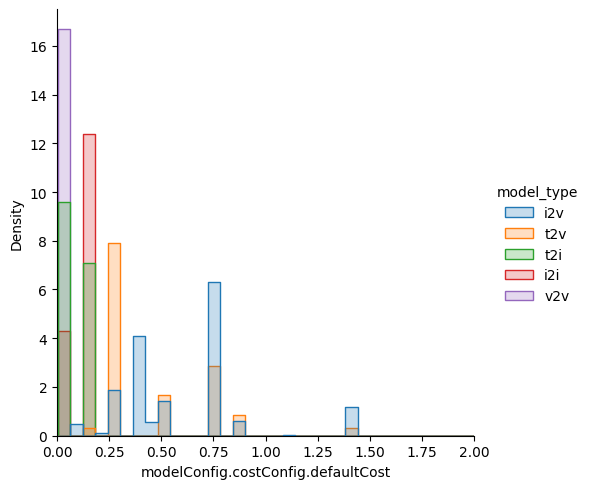

In [212]:
g = sns.displot(
    data=df[df.model_type.isin(['t2i','i2i','i2v','v2v','t2v'])],
    x="modelConfig.costConfig.defaultCost",
    hue="model_type",
    kind="hist",
    bins=100,
    element="step",
    stat="density",      # or "probability" / "percent"
    common_norm=False
)
g.set(xlim=(0, 2))

##### Basic breakdown per model_type

In [243]:
import seaborn as sns

def analyze_model_quality(df, model_type="t2i", top_n=8):
    # --- column checks / safe fallbacks ---
    if "qualityAnalysis.score" not in df.columns:
        print("Missing column: qualityAnalysis.score")
        return
    if "model_title_extracted" not in df.columns:
        print("Missing column: model_title_extracted")
        return

    df_sub = df[df["model_type"] == model_type].copy()

    # numeric score
    df_sub["quality_score"] = pd.to_numeric(df_sub["qualityAnalysis.score"], errors="coerce")

    # Check if we have any valid scores after coercion
    df_sub = df_sub.dropna(subset=["quality_score", "model_title_extracted"])
    if df_sub.empty:
        print(f"Skipping {model_type}: no valid quality scores.")
        return

    # rewritten prompt flag
    if "qualityAnalysis.rewrittenPrompt" in df_sub.columns:
        df_sub["has_rewrite"] = df_sub["qualityAnalysis.rewrittenPrompt"].notna() & (
            df_sub["qualityAnalysis.rewrittenPrompt"].astype(str).str.len() > 0
        )
    else:
        df_sub["has_rewrite"] = False

    # download flag
    if "resultDownloadedAt" in df_sub.columns:
        df_sub["was_downloaded"] = df_sub["resultDownloadedAt"].notna()
    else:
        df_sub["was_downloaded"] = False

    # keep top model titles
    top_titles = df_sub["model_title_extracted"].value_counts().head(top_n).index
    df_sub = df_sub[df_sub["model_title_extracted"].isin(top_titles)]

    # --- 1) Boxplot of score by model ---
    plt.figure(figsize=(12, 5))
    sns.boxplot(
        data=df_sub,
        x="model_title_extracted",
        y="quality_score",
        showfliers=False
    )
    plt.title(f"Quality score by model title ({model_type})")
    plt.xticks(rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    # --- 2) Score distributions by model (KDE) ---
    plt.figure(figsize=(12, 5))
    sns.kdeplot(
        data=df_sub,
        x="quality_score",
        hue="model_title_extracted",
        common_norm=False,
        fill=True,
        alpha=0.25
    )
    plt.title(f"Quality score distribution by model title ({model_type})")
    plt.tight_layout()
    plt.show()

    # --- 2.5) Boxplot of Cost by model ---
    if "modelConfig.costConfig.defaultCost" in df_sub.columns:
        df_sub["default_cost"] = pd.to_numeric(
            df_sub["modelConfig.costConfig.defaultCost"], errors="coerce"
        )

        avg_cost = (
            df_sub.groupby("model_title_extracted")["default_cost"]
            .mean()
            .sort_values(ascending=False)
        )

        # plt.figure(figsize=(10, 4))
        # sns.barplot(x=avg_cost.index, y=avg_cost.values, color="#59A14F")
        # plt.title(f"Average default cost by model title ({model_type})")
        # plt.ylabel("Average Cost")
        # plt.xticks(rotation=40, ha="right")
        # plt.tight_layout()
        # plt.show()
        plt.figure(figsize=(10, 4))
        sns.barplot(y=avg_cost.index, x=avg_cost.values, color="#59A14F")
        plt.title(f"Average default cost by model title ({model_type})")
        plt.xlabel("Average Cost")
        plt.ylabel("Model Title")
        plt.tight_layout()
        plt.show()
    else:
        print("Missing column: modelConfig.costConfig.defaultCost")

    ## Trying a time series of the average score by model title over time (weekly)
    df_ts = (
        df_sub[df_sub["model_title_extracted"].isin(top_titles)]
        .groupby(["isoweek", "model_title_extracted"])["default_cost"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=df_ts,
        x="isoweek",
        y="default_cost",
        hue="model_title_extracted",
        marker="o"
    )
    plt.title(f"Average Cost Over Time ({model_type})")
    plt.xlabel("ISO Week")
    plt.ylabel("Average Cost")
    plt.xticks(rotation=45, ha="right")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
    

    # --- 3) Download rate by model ---
    download_rate = (
        df_sub.groupby("model_title_extracted")["was_downloaded"]
        .mean()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(10, 4))
    sns.barplot(x=download_rate.index, y=download_rate.values, color="#4E79A7")
    plt.title(f"Download rate by model title ({model_type})")
    plt.ylabel("Download rate")
    plt.xticks(rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    # --- 4) Relationship: score vs download ---
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df_sub,
        x="was_downloaded",
        y="quality_score",
        showfliers=False
    )
    plt.title(f"Quality score vs download ({model_type})")
    plt.xlabel("Downloaded")
    plt.tight_layout()
    plt.show()

    # --- 5) Summary table ---
    summary = (
        df_sub.groupby("model_title_extracted")
        .agg(
            n=("quality_score", "size"),
            avg_score=("quality_score", "mean"),
            median_score=("quality_score", "median"),
            download_rate=("was_downloaded", "mean"),
            rewrite_rate=("has_rewrite", "mean"),
            avg_cost=("modelConfig.costConfig.defaultCost", "mean"),
            median_cost=("modelConfig.costConfig.defaultCost", "median"),
            quantile_25_cost=("modelConfig.costConfig.defaultCost", lambda x: x.quantile(0.25)),
            quantile_75_cost=("modelConfig.costConfig.defaultCost", lambda x: x.quantile(0.75))
        )
        .sort_values("avg_score", ascending=False)
    )

    ## 5) Scatter plot
    # scale bubble sizes (optional)
    # fig, ax = plt.subplots(figsize=(10, 6))
    # sns.scatterplot(
    #     data=summary.reset_index(),
    #     x="avg_score",
    #     y="avg_cost",
    #     size="n",
    #     hue="model_title_extracted",
    #     sizes=(60, 800),
    #     alpha=0.5,
    #     edgecolor="white",
    #     linewidth=0.5,
    #     ax=ax
    # )

    # ax.set_title(f"Avg Score vs Avg Cost (bubble size = n) ({model_type})")
    # ax.set_xlabel("Average Quality Score")
    # ax.set_ylabel("Average Cost")
    # ax.grid(alpha=0.5)

    # # move legend outside
    # ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Model", frameon=False)

    # plt.tight_layout()
    # plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # common settings
    plot_df = summary.reset_index()

    # Left: avg_score vs avg_cost
    sns.scatterplot(
        data=plot_df,
        x="avg_score",
        y="avg_cost",
        size="n",
        hue="model_title_extracted",
        sizes=(60, 800),
        alpha=0.5,
        edgecolor="white",
        linewidth=0.5,
        ax=axes[0],
        legend=False  # we'll add a single legend on the right
    )
    axes[0].set_title(f"Avg Score vs Avg Cost ({model_type})")
    axes[0].set_xlabel("Average Quality Score")
    axes[0].set_ylabel("Average Cost")
    axes[0].grid(alpha=0.5)

    # Right: download_rate vs avg_cost
    sns.scatterplot(
        data=plot_df,
        x="download_rate",
        y="avg_cost",
        size="n",
        hue="model_title_extracted",
        sizes=(60, 800),
        alpha=0.5,
        edgecolor="white",
        linewidth=0.5,
        ax=axes[1]
    )
    axes[1].set_title(f"Download Rate vs Avg Cost ({model_type})")
    axes[1].set_xlabel("Download Rate")
    axes[1].set_ylabel("")
    axes[1].grid(alpha=0.5)

    # single legend outside
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Model", frameon=False)

    plt.tight_layout()
    plt.show()

    display.display(summary.sort_values("n", ascending=False))

    return summary

In [244]:
# summary_i2i = analyze_model_quality(df, model_type="i2i", top_n=8)

Analyzing quality for model type: i2i


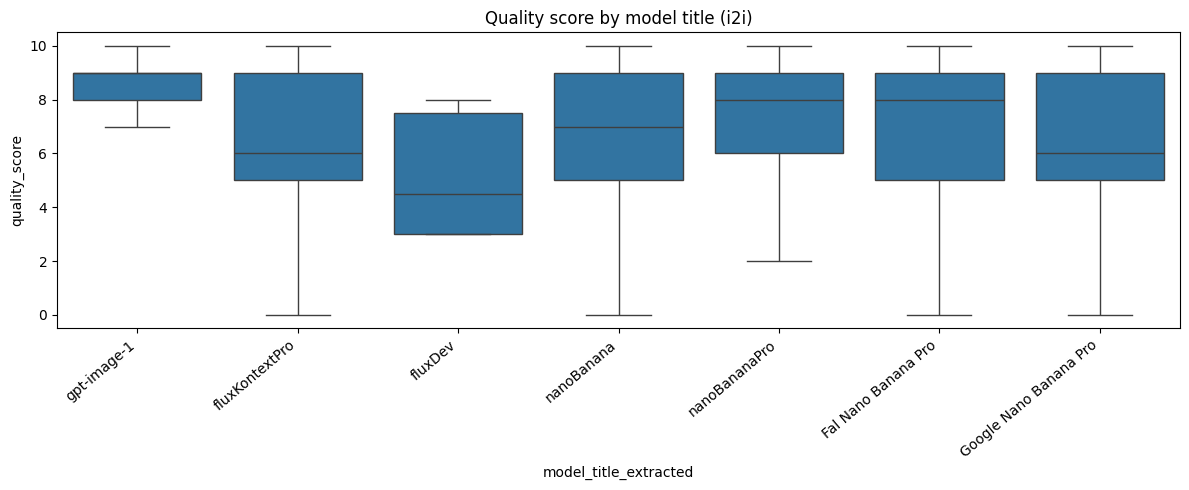

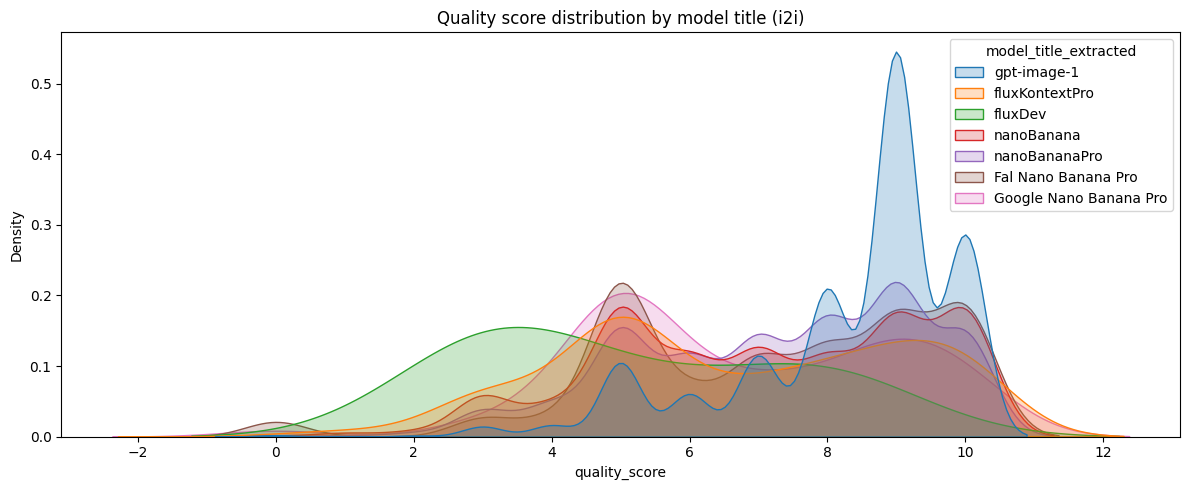

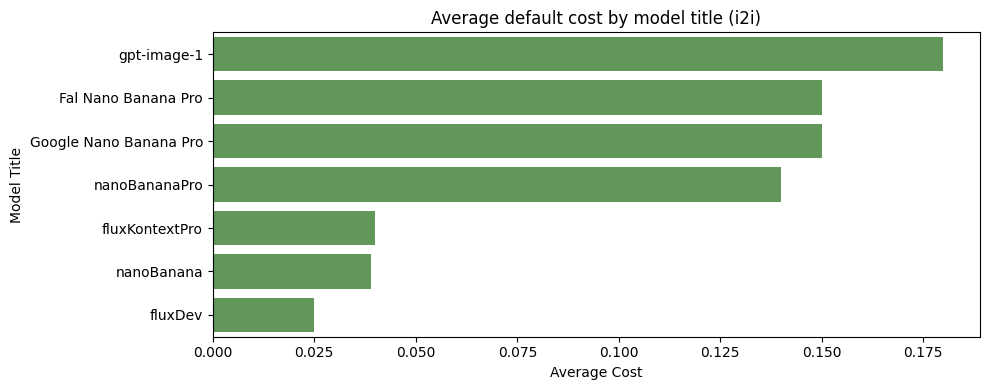

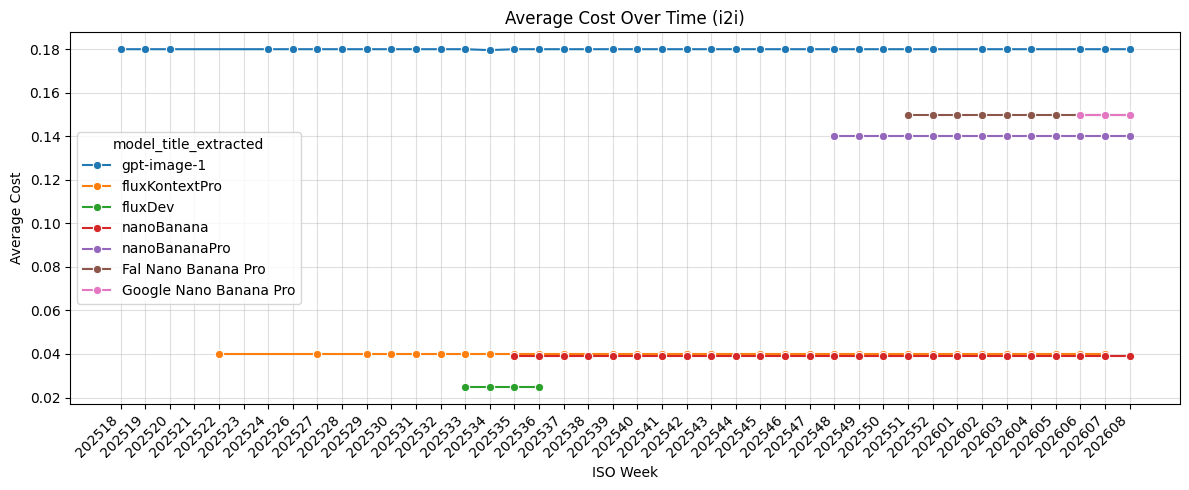

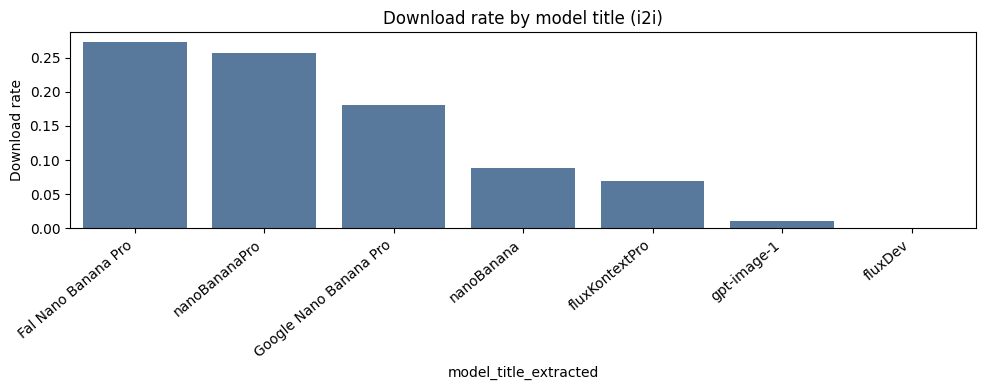

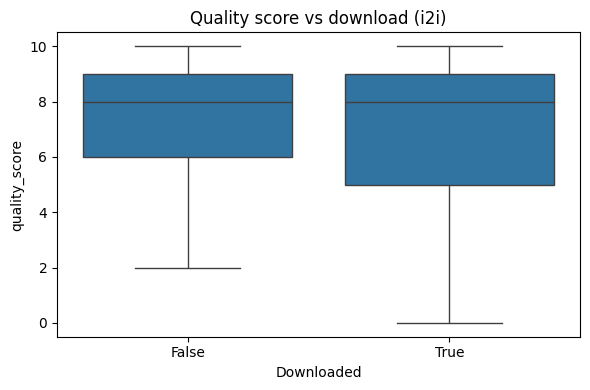

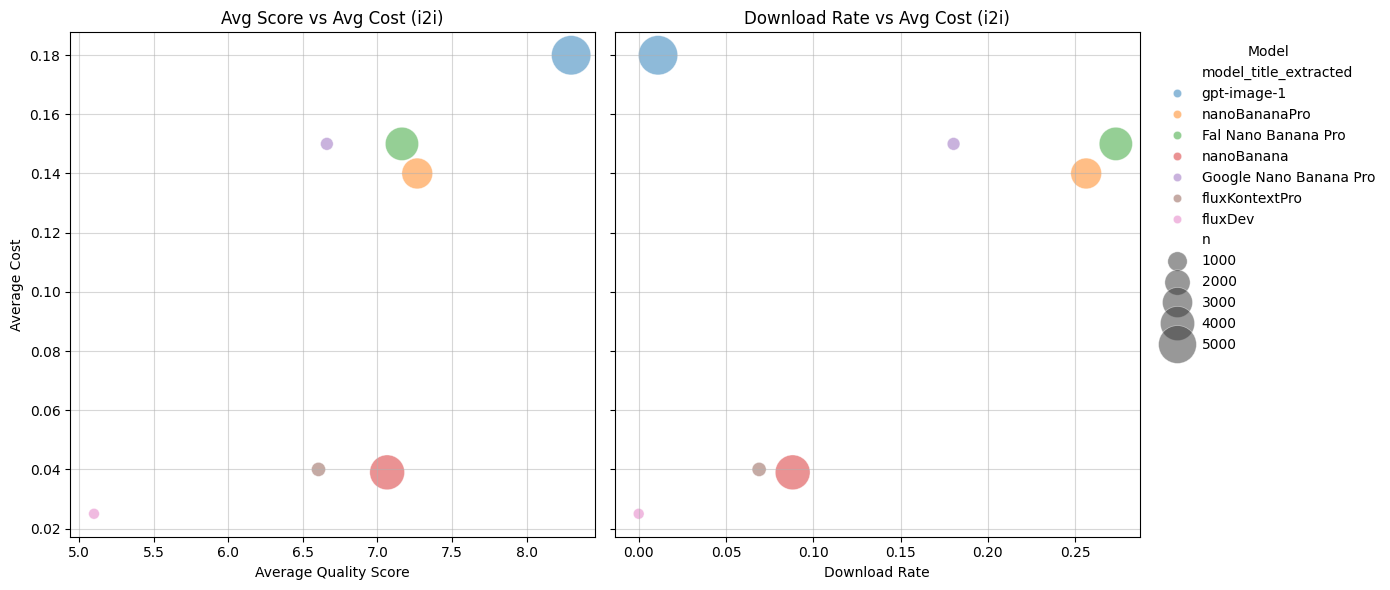

n  avg_score  median_score  download_rate  \
model_title_extracted                                                  
gpt-image-1             5413   8.298725           9.0       0.011084   
nanoBanana              4151   7.065285           7.0       0.088172   
Fal Nano Banana Pro     3751   7.164489           8.0       0.273260   
nanoBananaPro           3153   7.267047           8.0       0.256264   
fluxKontextPro           319   6.605016           6.0       0.068966   
Google Nano Banana Pro   183   6.661202           6.0       0.180328   
fluxDev                   10   5.100000           4.5       0.000000   

                        rewrite_rate  avg_cost  median_cost  quantile_25_cost  \
model_title_extracted                                                           
gpt-image-1                 0.539442  0.179948        0.180             0.180   
nanoBanana                  0.703204  0.039000        0.039             0.039   
Fal Nano Banana Pro         0.671288  0.150000        0.150             0.150   
nanoBananaPro               0.711386  0.140000        0.140             0.140   
fluxKontextPro              0.717868  0.040000        0.040             0.040   
Google Nano Banana Pro      0.743169  0.150000        0.150             0.150   
fluxDev                     1.000000  0.025000        0.025             0.025   

                        quantile_75_cost  
model_title_extracted                     
gpt-image-1                        0.180  
nanoBanana                         0.039  
Fal Nano Banana Pro                0.150  
nanoBananaPro                      0.140  
fluxKontextPro                     0.040  
Google Nano Banana Pro             0.150  
fluxDev                            0.025




Analyzing quality for model type: t2i


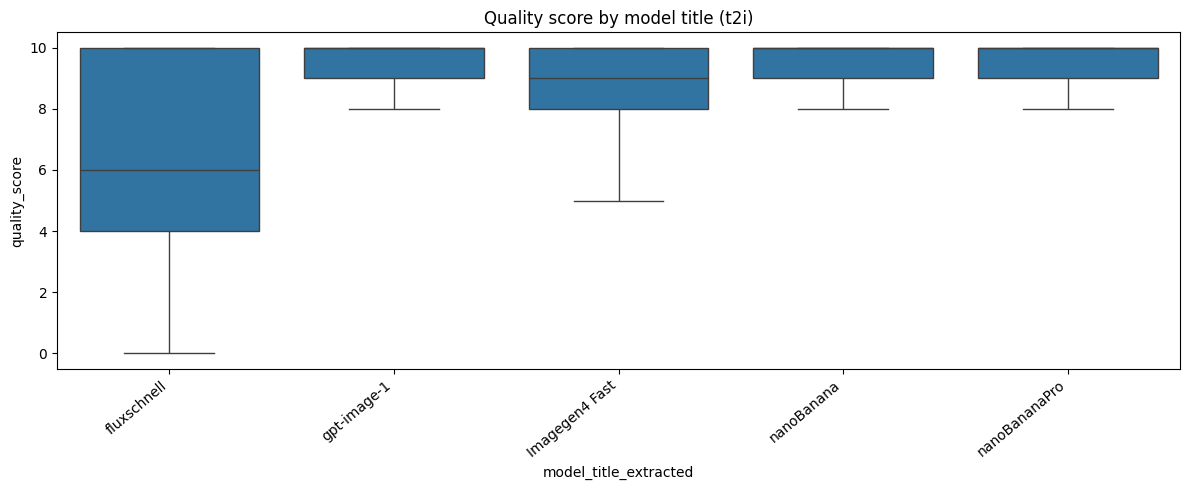

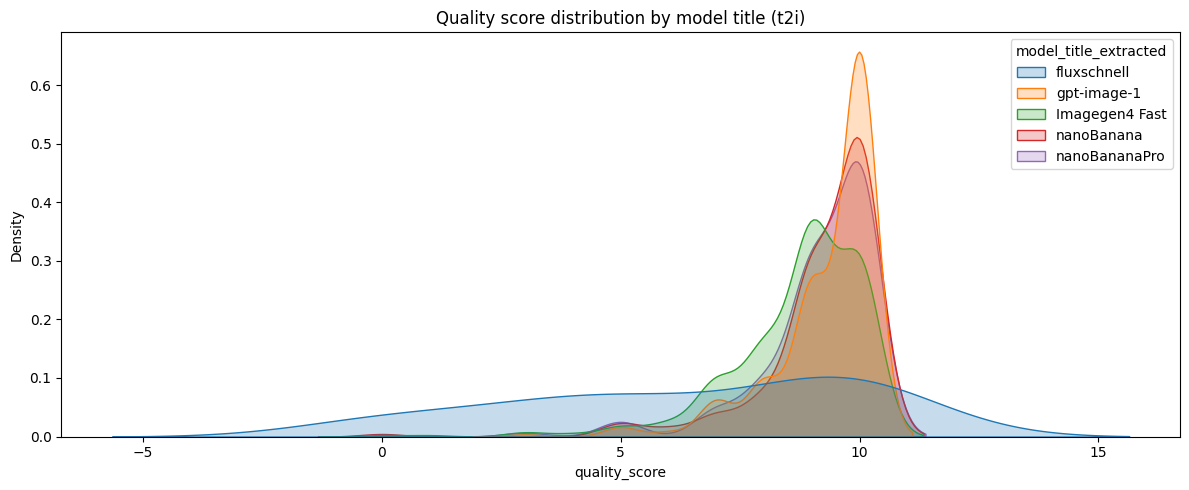

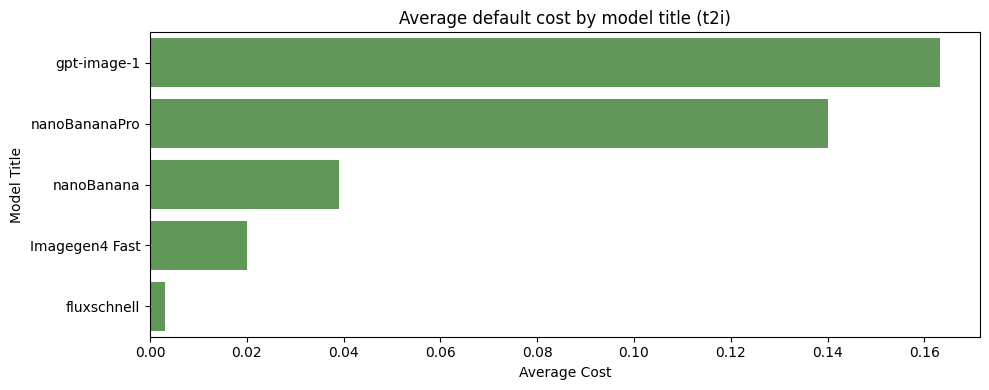

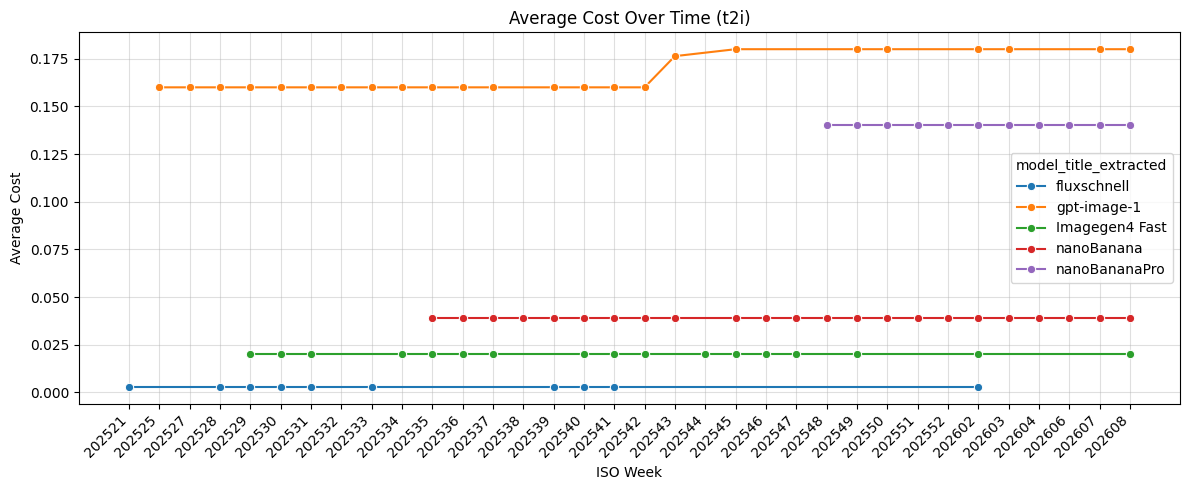

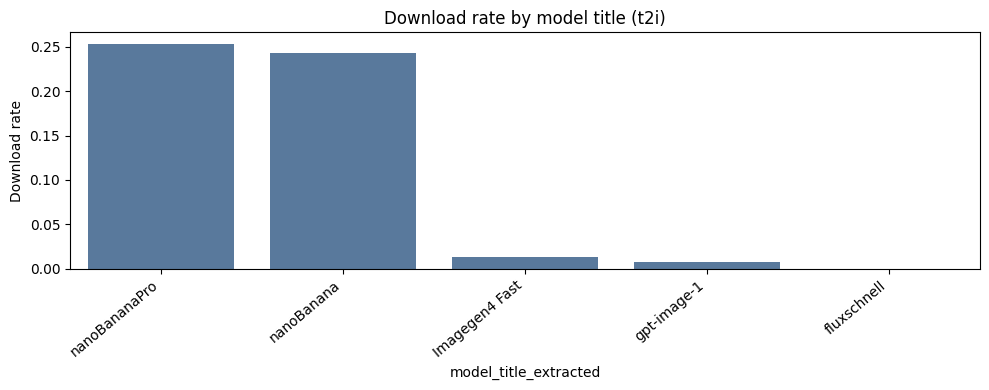

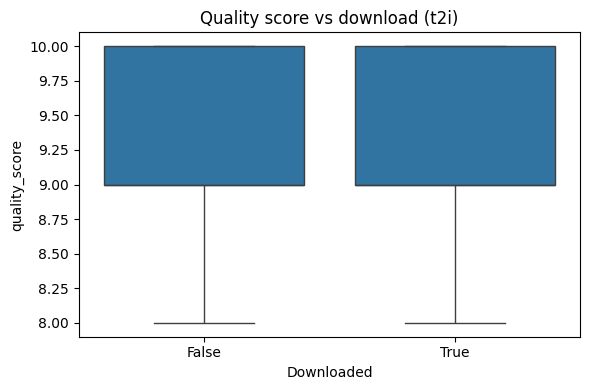

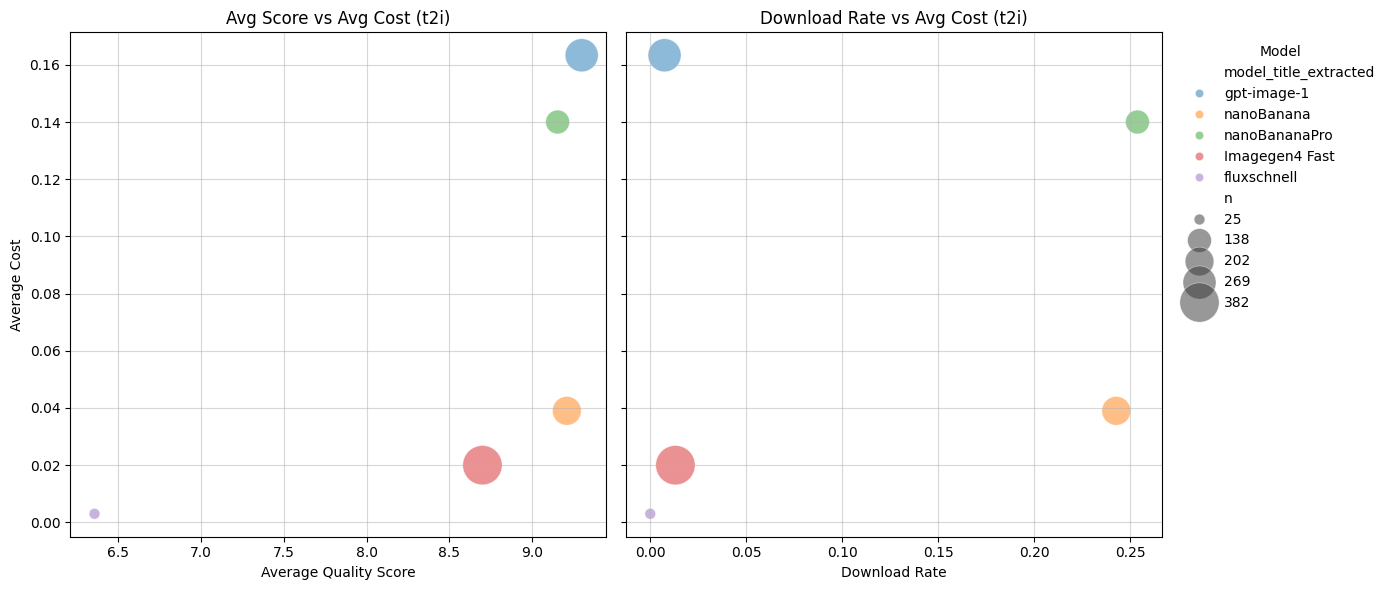

n  avg_score  median_score  download_rate  \
model_title_extracted                                                
Imagegen4 Fast         382   8.698953           9.0       0.013089   
gpt-image-1            269   9.297398          10.0       0.007435   
nanoBanana             202   9.207921          10.0       0.242574   
nanoBananaPro          138   9.152174          10.0       0.253623   
fluxschnell             25   6.360000           6.0       0.000000   

                       rewrite_rate  avg_cost  median_cost  quantile_25_cost  \
model_title_extracted                                                          
Imagegen4 Fast             0.494764  0.020000        0.020             0.020   
gpt-image-1                0.278810  0.163346        0.160             0.160   
nanoBanana                 0.252475  0.039000        0.039             0.039   
nanoBananaPro              0.340580  0.140000        0.140             0.140   
fluxschnell                0.440000  0.003000        0.003             0.003   

                       quantile_75_cost  
model_title_extracted                    
Imagegen4 Fast                    0.020  
gpt-image-1                       0.160  
nanoBanana                        0.039  
nanoBananaPro                     0.140  
fluxschnell                       0.003




Analyzing quality for model type: i2v


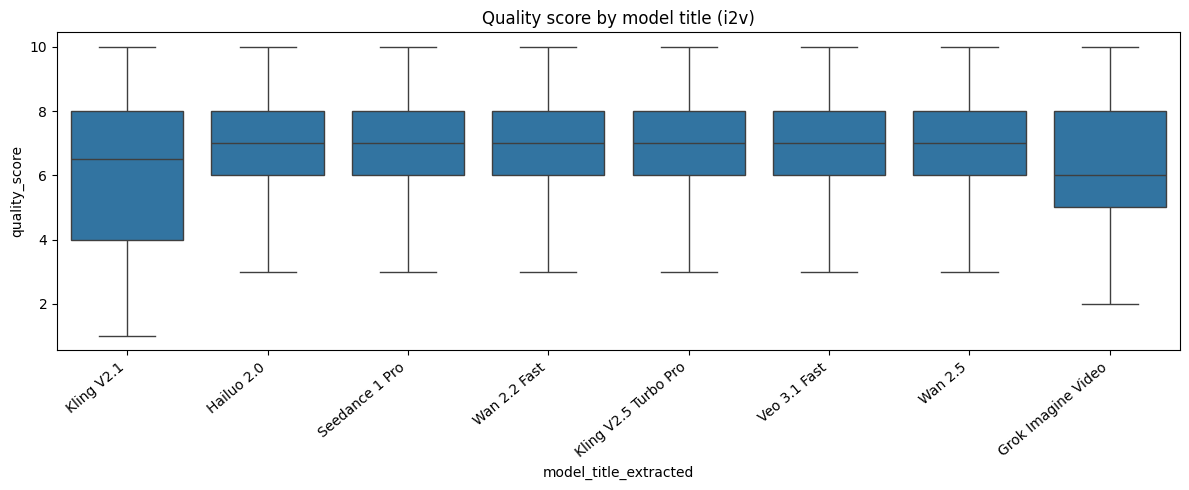

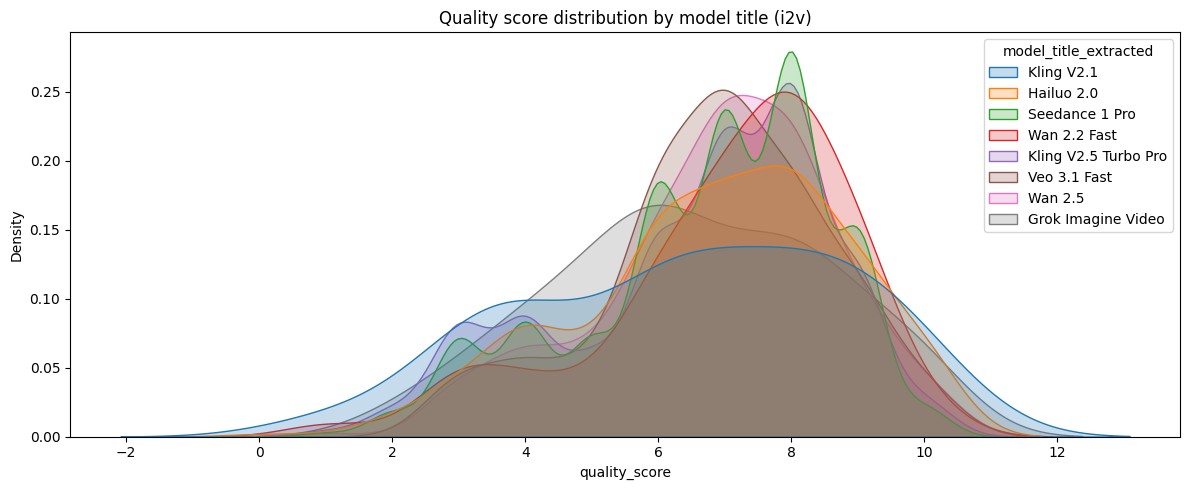

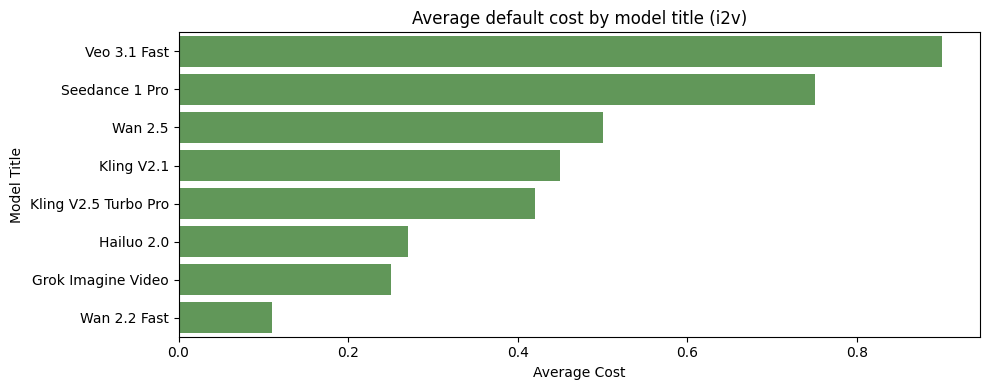

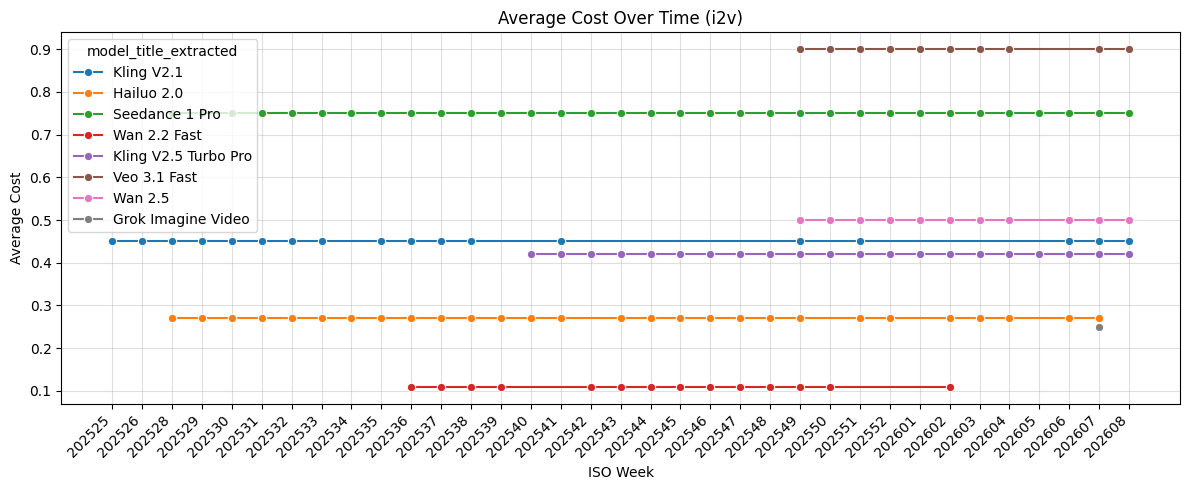

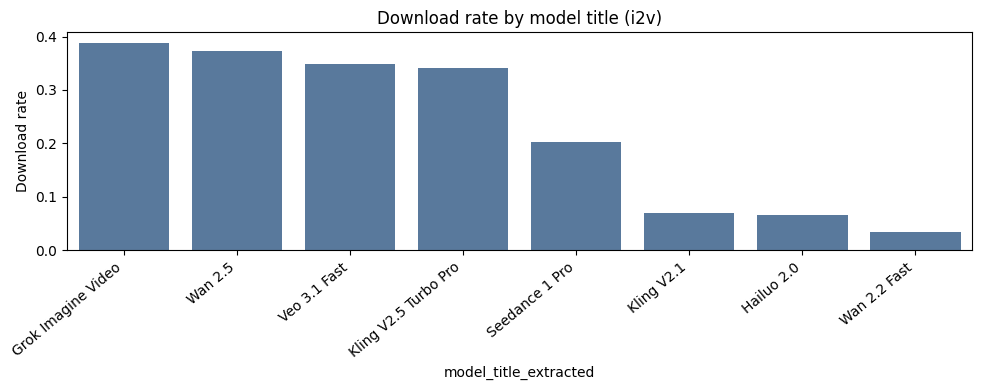

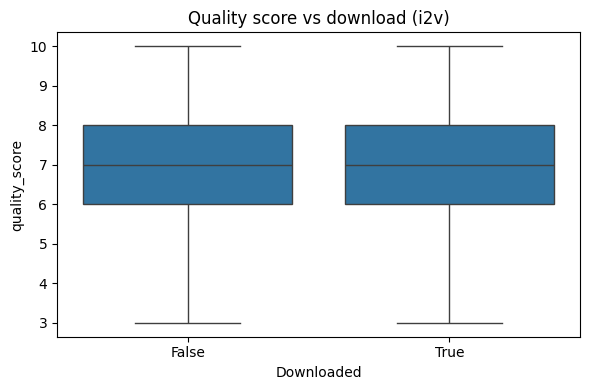

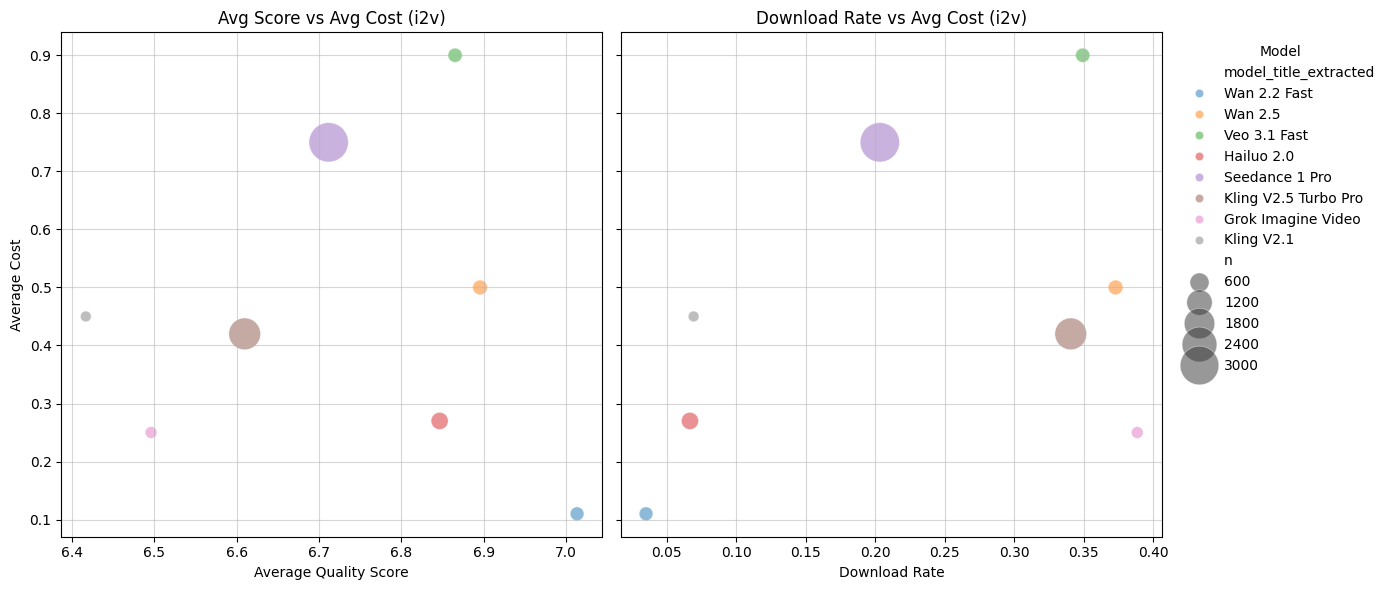

n  avg_score  median_score  download_rate  \
model_title_extracted                                                 
Seedance 1 Pro         3113   6.711532           7.0       0.203341   
Kling V2.5 Turbo Pro   1967   6.609558           7.0       0.340620   
Hailuo 2.0              449   6.846325           7.0       0.066815   
Wan 2.5                 287   6.895470           7.0       0.372822   
Veo 3.1 Fast            252   6.865079           7.0       0.349206   
Wan 2.2 Fast            227   7.013216           7.0       0.035242   
Grok Imagine Video      121   6.495868           6.0       0.388430   
Kling V2.1               72   6.416667           6.5       0.069444   

                       rewrite_rate  avg_cost  median_cost  quantile_25_cost  \
model_title_extracted                                                          
Seedance 1 Pro             0.895599      0.75         0.75              0.75   
Kling V2.5 Turbo Pro       0.934418      0.42         0.42              0.42   
Hailuo 2.0                 0.721604      0.27         0.27              0.27   
Wan 2.5                    0.923345      0.50         0.50              0.50   
Veo 3.1 Fast               0.916667      0.90         0.90              0.90   
Wan 2.2 Fast               0.938326      0.11         0.11              0.11   
Grok Imagine Video         0.867769      0.25         0.25              0.25   
Kling V2.1                 0.791667      0.45         0.45              0.45   

                       quantile_75_cost  
model_title_extracted                    
Seedance 1 Pro                     0.75  
Kling V2.5 Turbo Pro               0.42  
Hailuo 2.0                         0.27  
Wan 2.5                            0.50  
Veo 3.1 Fast                       0.90  
Wan 2.2 Fast                       0.11  
Grok Imagine Video                 0.25  
Kling V2.1                         0.45




Analyzing quality for model type: t2s
Skipping t2s: no valid quality scores.





In [245]:
main_model_types = ['i2i', 't2i', 'i2v','t2s']
for task in main_model_types:
    print(f"Analyzing quality for model type: {task}")
    summary = analyze_model_quality(df, model_type=task, top_n=8)
    print("\n\n")

# FAQs

#### Do models that perform the same task type (i2i, i2v, etc.) but come from different providers (OPENAI, REPLICATE, …) have the same price?

To perform the analysis and looking at previous findings we will look at :
- i2i tasks and models such as gpt-image-1 that has OPENAI AND REPLICATE as provider

and others that eventually satify the conditions.

Answer: It feels that replicate might allow for certain cheaper calls of some models, but then pricing between REPLICATE and OPENAI is the same. 

In [150]:
# Create the code such that it finds for i2i model_type, the model_title_extracted that have different providers. Give me the list of those model_title_extracted that have more than 1 provider. This will help us understand which models are offered by multiple providers and if there are any differences in cost or quality between them.
from IPython import display
for task in ['i2i','i2v','t2s','t2i']: 
    df_i2i = df[df['model_type'] == task]
    model_provider_counts = df_i2i.groupby(['model_title_extracted', 'modelConfig.provider']).size().unstack(fill_value=0)
    model_provider_counts['num_providers'] = (model_provider_counts > 0).sum(axis=1)
    models_multiple_providers = model_provider_counts[model_provider_counts['num_providers'] > 1].index.tolist()
    print(f"{task} models with multiple providers:", models_multiple_providers)
    display.display(model_provider_counts)

i2i models with multiple providers: ['gpt-image-1']


modelConfig.provider    FAL_AI  GOOGLE_GEMINI  OPENAI  REPLICATE  \
model_title_extracted                                              
Fal Nano Banana Pro       4127              0       0          0   
Google Nano Banana Pro       0            207       0          0   
fluxDev                      0              0       0        172   
fluxKontextPro               0              0       0        739   
fluxschnell                  0              0       0         12   
gpt-image-1                  0              0    7918       1700   
nanoBanana                   0              0       0       4442   
nanoBananaPro                0              0       0       3717   

modelConfig.provider    num_providers  
model_title_extracted                  
Fal Nano Banana Pro                 1  
Google Nano Banana Pro              1  
fluxDev                             1  
fluxKontextPro                      1  
fluxschnell                         1  
gpt-image-1                         2  
nanoBanana                          1  
nanoBananaPro                       1

i2v models with multiple providers: []


modelConfig.provider     FAL_AI  REPLICATE  VIDU  num_providers
model_title_extracted                                          
Fal AI                        5          0     0              1
Grok Imagine Video            0        148     0              1
Hailuo 2.0                  970          0     0              1
Kling 3 Pro                  21          0     0              1
Kling 3 Standard              5          0     0              1
Kling V1.6                    0        102     0              1
Kling V1.6 Pro                0        320     0              1
Kling V2.0                    0        751     0              1
Kling V2.1                    0        349     0              1
Kling V2.5 Turbo Pro          0       2481     0              1
Minimax I2V-01                0          1     0              1
Minimax I2V-01-Director       0         12     0              1
Minimax I2V-01-Live           0        193     0              1
PixVerse V5                   0         62     0              1
Seedance 1 Pro                0       4031     0              1
Veo 3.1 Fast                  0        378     0              1
Veo2                          0         38     0              1
Vidu 1.5                      0          0     1              1
Vidu 2.0                      0          0    69              1
Wan 2.2 14B                  72          0     0              1
Wan 2.2 Fast                  0        319     0              1
Wan 2.2 a14B                  2          0     0              1
Wan 2.5                       0        404     0              1

t2s models with multiple providers: ['eleven_flash_v2_5', 'eleven_multilingual_v2', 'eleven_turbo_v2']


modelConfig.provider    ELEVEN_LABS  VOICE_GEN_SERVICE  \
model_title_extracted                                    
ash                               0                 16   
coral                             0                 17   
eleven_flash_v2_5                 6                  4   
eleven_multilingual_v2           11                  9   
eleven_turbo_v2                 595                 82   
eleven_turbo_v2_5                 0                  0   
eleven_v3                         0                  0   
fable                             0                129   
unknown_t2s_model                 0                  0   
verse                             0                 50   

modelConfig.provider    VOICE_GEN_SERVICE_DUAL_GENERATION  num_providers  
model_title_extracted                                                     
ash                                                     0              1  
coral                                                   0              1  
eleven_flash_v2_5                                     112              3  
eleven_multilingual_v2                                588              3  
eleven_turbo_v2                                       253              3  
eleven_turbo_v2_5                                      15              1  
eleven_v3                                            3062              1  
fable                                                   0              1  
unknown_t2s_model                                     295              1  
verse                                                   0              1

t2i models with multiple providers: ['Grok 2 Image', 'gpt-image-1']


modelConfig.provider   FAL_AI  GROKAI  OPENAI  REPLICATE  XAI  num_providers
model_title_extracted                                                       
Fal Nano Banana Pro         1       0       0          0    0              1
Grok 2 Image                0       1       0          0    1              2
Imagegen4 Fast            395       0       0          0    0              1
fluxKontextPro              0       0       0         57    0              1
fluxschnell                 0       0       0        511    0              1
gpt-image-1                 0       0    2077        625    0              2
nanoBanana                  0       0       0        251    0              1
nanoBananaPro               0       0       0        151    0              1

From the image above it feels that the situations that match the requirements of the questions are:

- For i2i --> model_title_extracted = gpt-image-1 --> modelConfig.provider [OPENAI , REPLICATE]

- For i2v [] 

- For t2s --> [] --> Mapping needs refinement

- For t2i   
    -  model_title_extracted = gpt-image-1 --> modelConfig.provider [OPENAI , REPLICATE]

    -  model_title_extracted = Grok 2 Image	 --> modelConfig.provider [GROKAI , XAI]

In [163]:
# Let's build a function that takes the model_type, model_title_extracted and provider as input and gives us the average cost and quality score for that combination. This will help us compare the performance of the same model across different providers.
def compare_model_provider(model_type, model_title):
    df_filtered = df[(df['model_type'] == model_type) & (df['model_title_extracted'] == model_title)]
    display.display(df_filtered.groupby('modelConfig.provider')['modelConfig.costConfig.defaultCost'].describe().T)
    try:
        display.display(df_filtered.groupby('modelConfig.provider')['modelConfig.costConfig.defaultCost'].value_counts(bins=10).T)
    except Exception as e:
        print(f"Error displaying value counts: {e}")
    return 'Done'

In [164]:
# For i2i + gpt-image-1, let's analyze the cost distribution by provider. This will help us understand if there are any cost differences between providers for the same model, which could be due to different underlying implementations, optimizations, or pricing strategies.
compare_model_provider('i2i', 'gpt-image-1')

modelConfig.provider       OPENAI  REPLICATE
count                 7549.000000    1700.00
mean                     0.169872       0.18
std                      0.038845       0.00
min                      0.020000       0.18
25%                      0.180000       0.18
50%                      0.180000       0.18
75%                      0.180000       0.18
max                      0.180000       0.18

modelConfig.provider  modelConfig.costConfig.defaultCost
OPENAI                (0.164, 0.18]                         7068
                      (0.0188, 0.036]                        456
                      (0.036, 0.052]                          25
                      (0.052, 0.068]                           0
                      (0.068, 0.084]                           0
                      (0.084, 0.1]                             0
                      (0.1, 0.116]                             0
                      (0.116, 0.132]                           0
                      (0.132, 0.148]                           0
                      (0.148, 0.164]                           0
REPLICATE             (0.17996, 0.18]                       1700
                      (0.17981, 0.17986]                       0
                      (0.17986, 0.17989]                       0
                      (0.17989, 0.17993]                       0
                      (0.17993, 0

'Done'

In [166]:
compare_model_provider('t2i', 'gpt-image-1')

modelConfig.provider       OPENAI     REPLICATE
count                 1668.000000  6.250000e+02
mean                     0.089676  1.800000e-01
std                      0.075660  2.777781e-17
min                      0.020000  1.800000e-01
25%                      0.020000  1.800000e-01
50%                      0.020000  1.800000e-01
75%                      0.180000  1.800000e-01
max                      0.180000  1.800000e-01

modelConfig.provider  modelConfig.costConfig.defaultCost
OPENAI                (0.0188, 0.036]                       899
                      (0.164, 0.18]                         428
                      (0.148, 0.164]                        341
                      (0.036, 0.052]                          0
                      (0.052, 0.068]                          0
                      (0.068, 0.084]                          0
                      (0.084, 0.1]                            0
                      (0.1, 0.116]                            0
                      (0.116, 0.132]                          0
                      (0.132, 0.148]                          0
REPLICATE             (0.17996, 0.18]                       625
                      (0.17981, 0.17986]                      0
                      (0.17986, 0.17989]                      0
                      (0.17989, 0.17993]                      0
                      (0.17993, 0.17996]       

'Done'

In [167]:
compare_model_provider('t2i', 'Grok 2 Image')

modelConfig.provider  GROKAI  XAI
count                    0.0  0.0
mean                     NaN  NaN
std                      NaN  NaN
min                      NaN  NaN
25%                      NaN  NaN
50%                      NaN  NaN
75%                      NaN  NaN
max                      NaN  NaN

Error displaying value counts: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg


'Done'

/var/folders/ng/mrdj2gwd7vj4rpdzt5f417g80000gp/T/ipykernel_33464/236295384.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Provider')


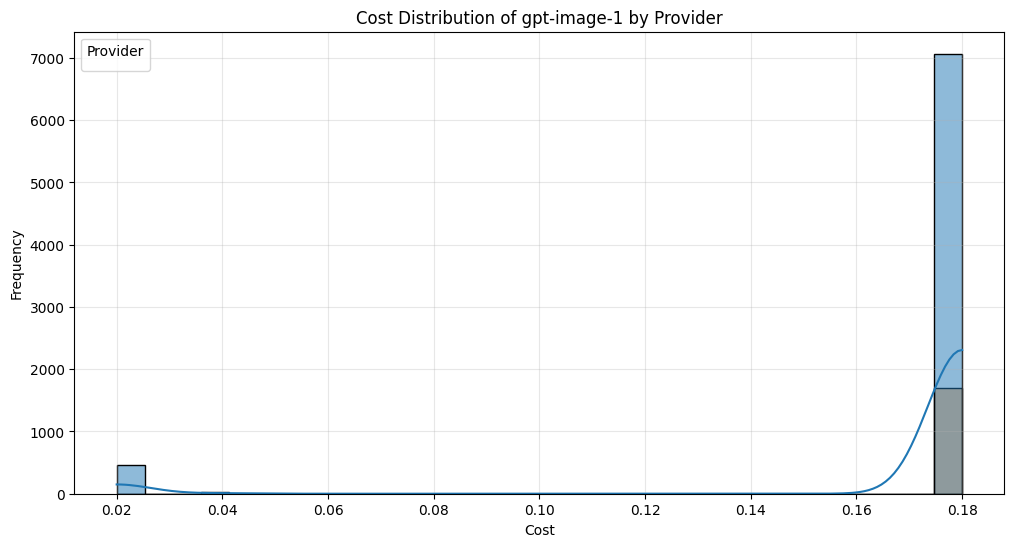

In [142]:
# Let's normalize the cost by provider to see if there are any differences in the distribution of costs across providers. We can use a boxplot for that.
plt.figure(figsize=(12, 6))
sns.histplot(data=df_gpt_image_1, x='modelConfig.costConfig.defaultCost', hue='modelConfig.provider', bins=30, kde=True)
plt.title('Cost Distribution of gpt-image-1 by Provider')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.legend(title='Provider')
plt.grid(alpha=0.3)
plt.show()

In [139]:
df_gpt_image_1[['modelConfig.provider','modelConfig.costConfig.defaultCost']].sample(10).T

6430    18866      20913      31842  \
modelConfig.provider                OPENAI  OPENAI  REPLICATE  REPLICATE   
modelConfig.costConfig.defaultCost    0.18    0.18       0.18       0.18   

                                        25049      22803   12933   2451   \
modelConfig.provider                REPLICATE  REPLICATE  OPENAI  OPENAI   
modelConfig.costConfig.defaultCost       0.18       0.18    0.18    0.18   

                                        20818   4872   
modelConfig.provider                REPLICATE  OPENAI  
modelConfig.costConfig.defaultCost       0.18     NaN

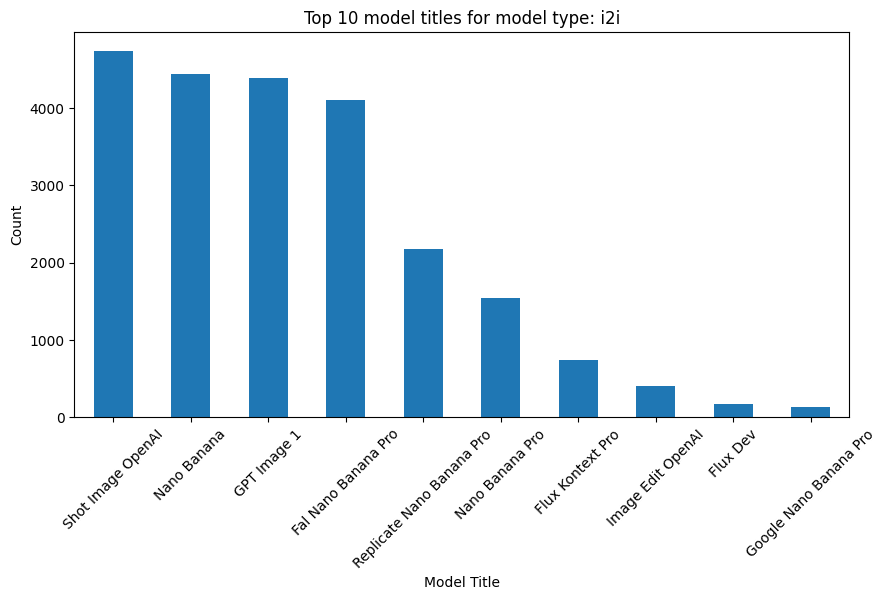

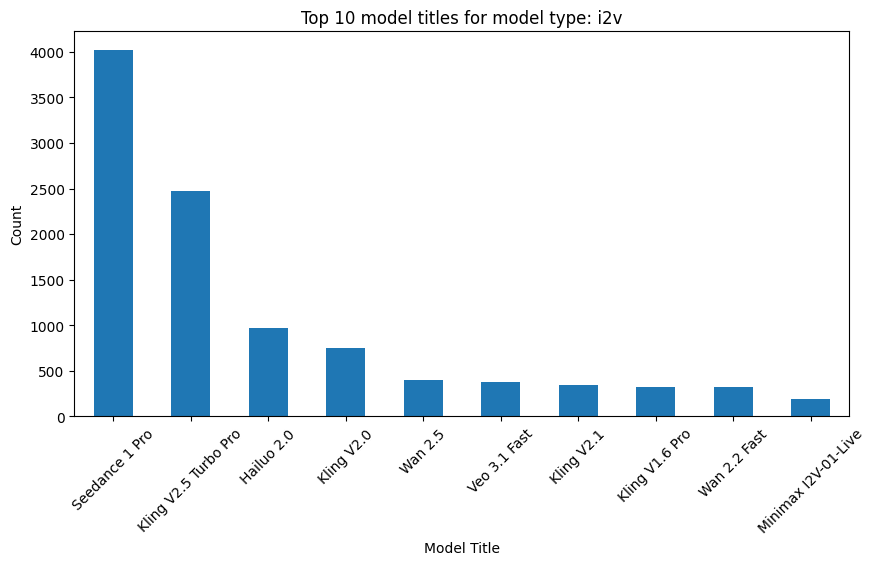

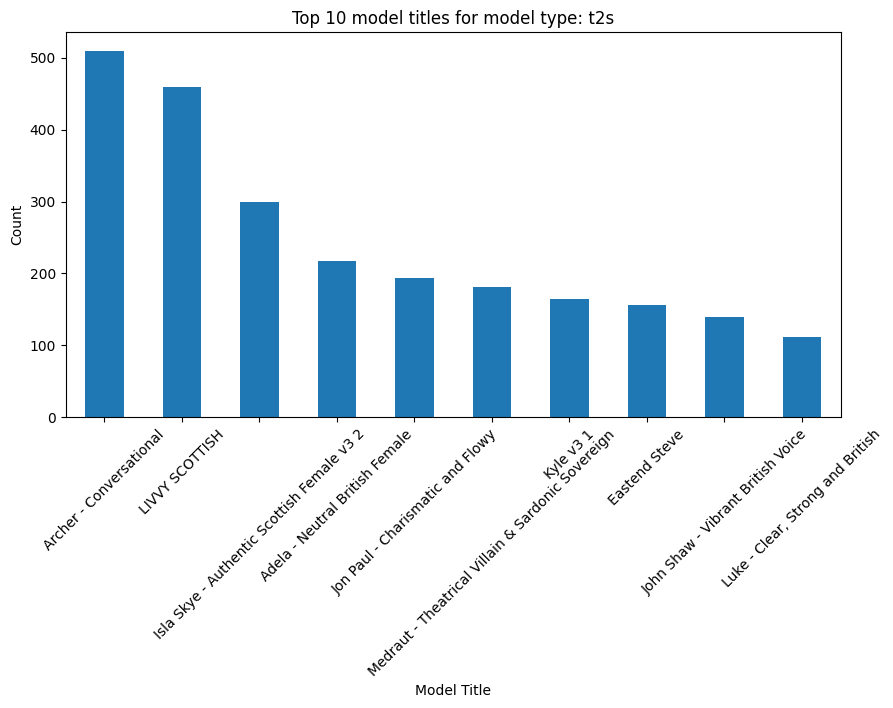

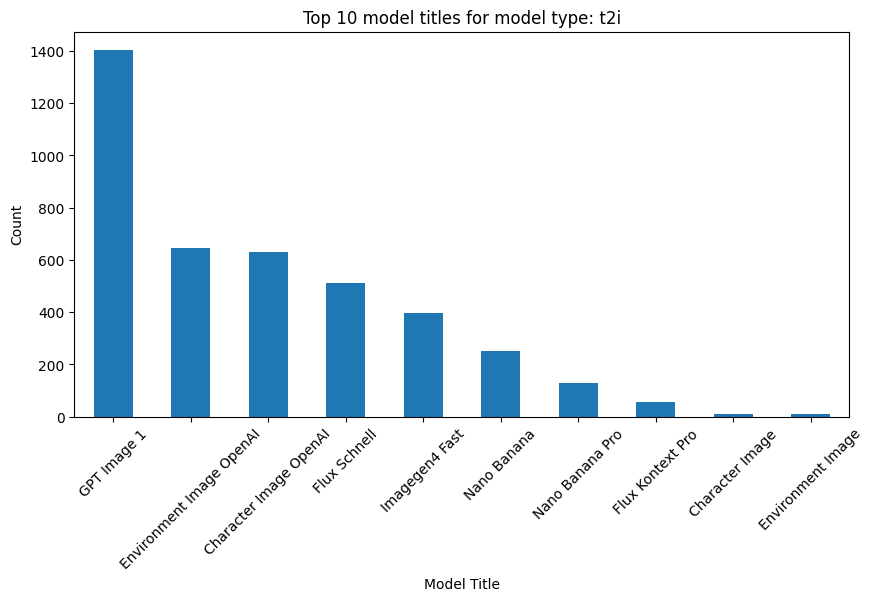

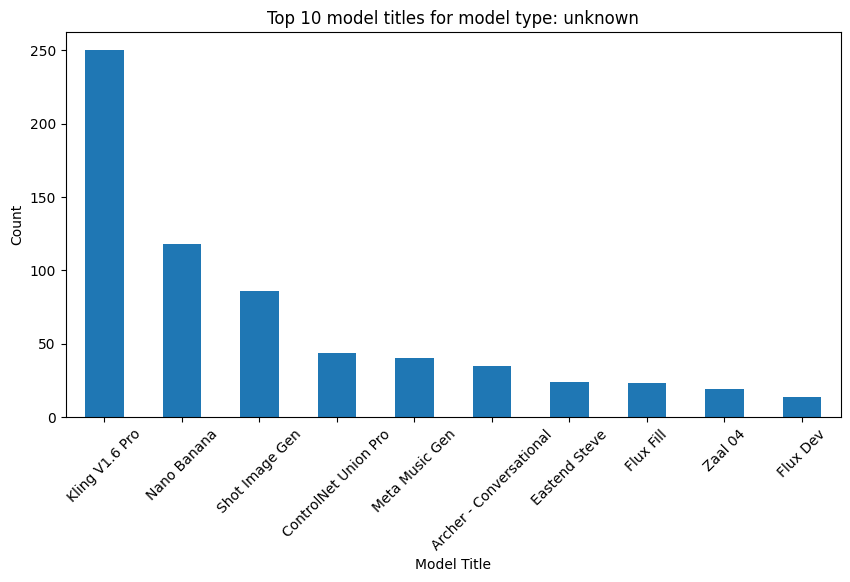

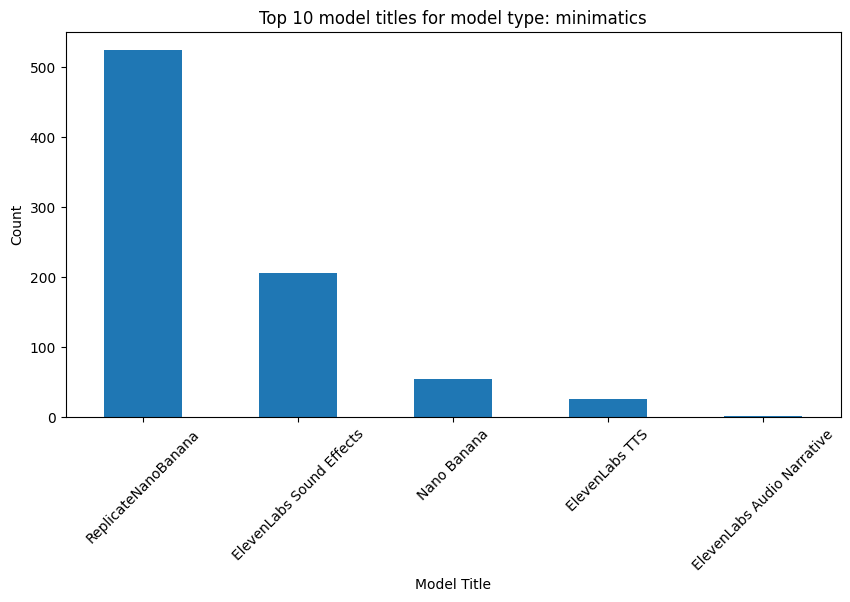

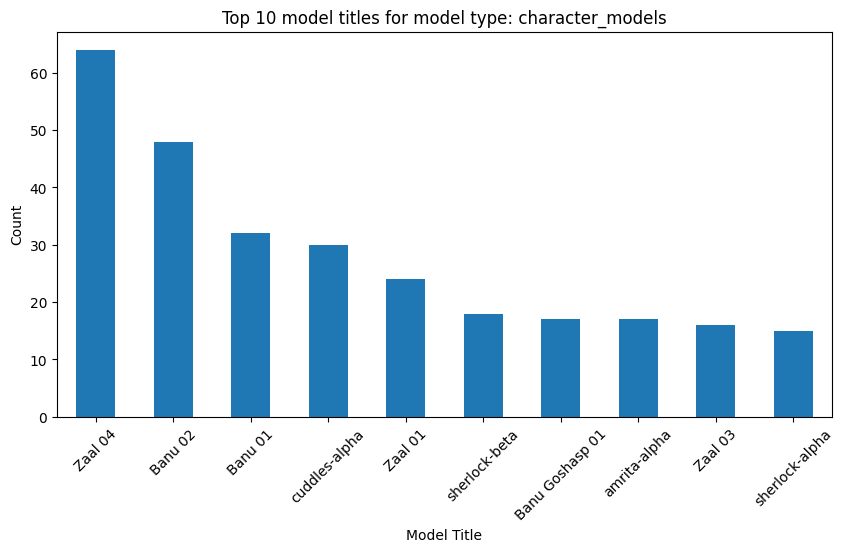

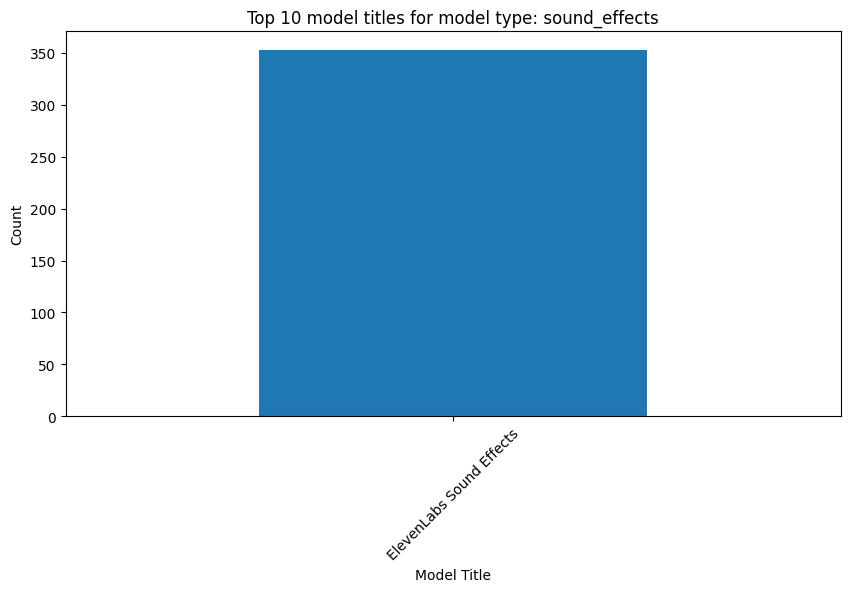

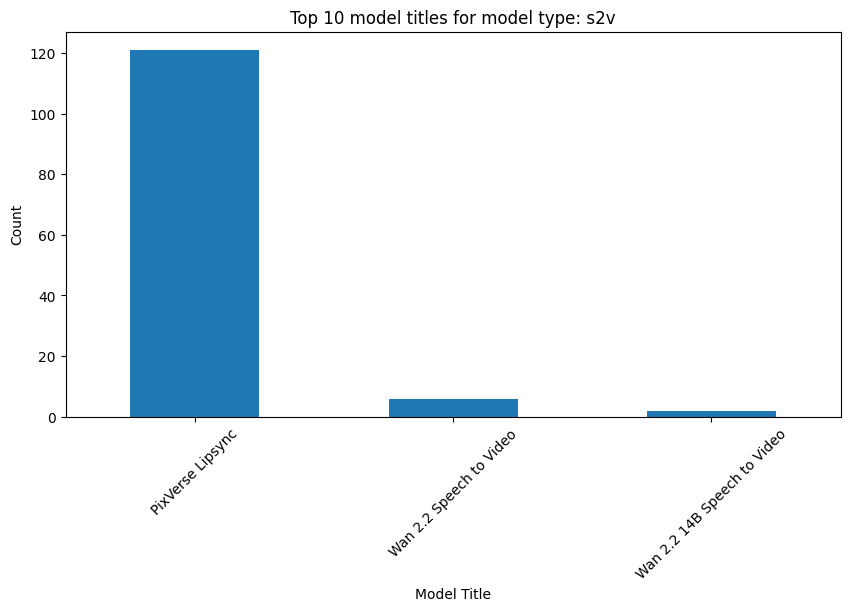

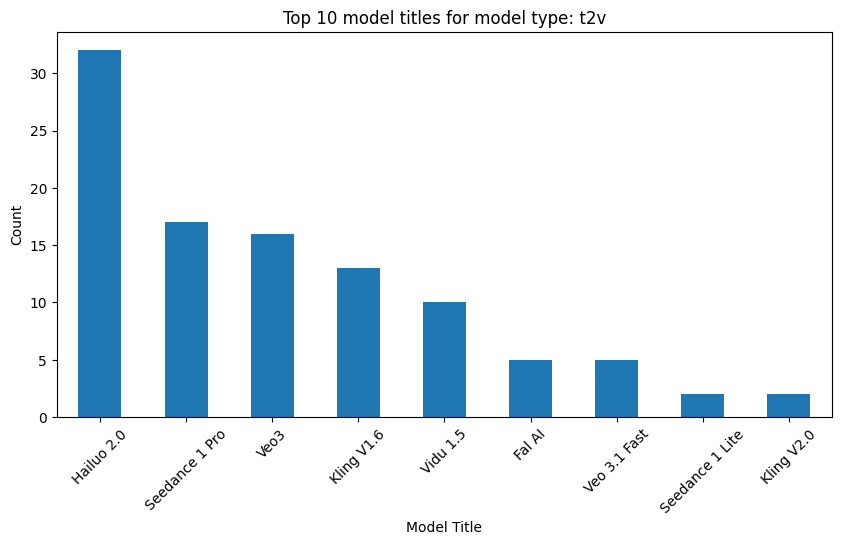

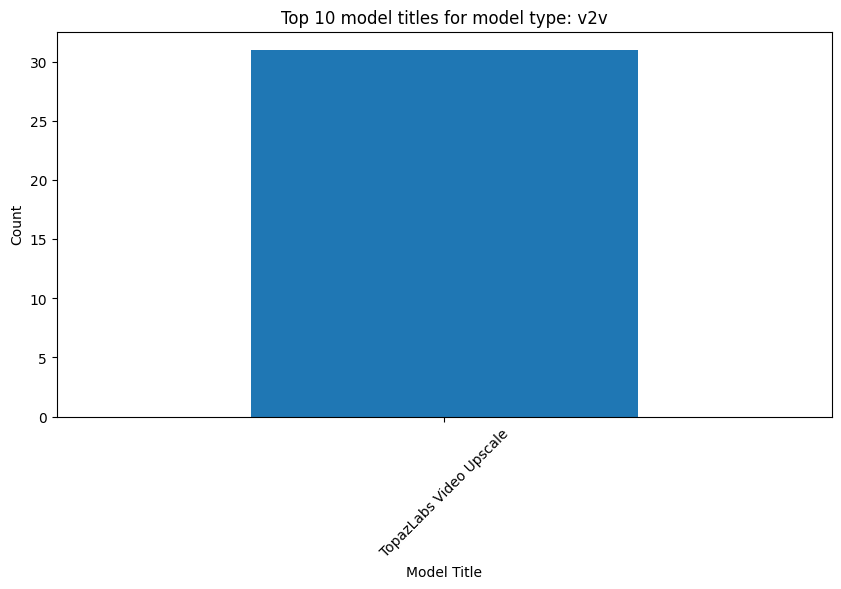

In [153]:
list_model_types = df['model_type'].value_counts().index.tolist() 
for model_type in list_model_types:
    # Let's make a cool visualization of the most common model titles for each model type
    #print(f"Model type: {model_type}")
    df_type = df[df['model_type'] == model_type]['modelConfig.modelTitle'].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    df_type.head(10).plot(kind='bar', ax=ax)
    ax.set_title(f"Top 10 model titles for model type: {model_type}")
    ax.set_xlabel("Model Title")
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


In [154]:
df.sample(5)

_id                                 jobId  \
36155  6954eea579df01c2309c2c53  b0bcbb0a-2d8d-43a9-be07-428ee64e56ae   
19509  68f5a2839bea836727cfce61  2162a129-eb94-4171-ad18-c241c9f7bbf1   
31167  693e49ce8bfb0d98fd2cccd2  808e3bf7-0eec-4f67-b614-29717917cbc6   
20190  68fb4cd84c8544efd45aa001  b2fc4641-8c94-43db-95ed-acbd7c0482bb   
20975  68ff72fb4c8544efd45c7f68  3216eaff-d016-4295-8c4e-51617b5d1fec   

                                     userId               createdAt  \
36155  3e1f37e7-c1df-45c4-ace4-239a303e5bd6 2025-12-31 09:36:37.612   
19509  5daf3fb7-34ed-4e67-8790-89cee4180d05 2025-10-20 02:46:27.899   
31167  2ea9565c-f1c2-43c5-9517-9c66fad23e66 2025-12-14 05:23:26.929   
20190  de4b6003-2c85-49d0-bde5-b3b28dd9c1f4 2025-10-24 09:54:32.308   
20975  de4b6003-2c85-49d0-bde5-b3b28dd9c1f4 2025-10-27 13:26:19.110   

          status               updatedAt modelConfig.name  \
36155  completed 2025-12-31 09:37:51.912   Image to Image   
19509  completed 2025-10-20 02:53:09.431        ShotImage   
31167  completed 2025-12-14 05:23:26.929   Text to Speech   
20190  completed 2025-10-24 09:55:25.259   Image to Video   
20975  completed 2025-10-27 13:30:37.298   Image to Video   

             modelConfig.id modelConfig.outputType modelConfig.modelType  \
36155     i2i-nanoBananaPro                  IMAGE             IMAGE_GEN   
19509       i2i-gpt-image-1                  IMAGE             IMAGE_GEN   
31167  jXuksIgonIKWaPC8gdwP                  AUDIO                   TTS   
20190        i2vSeedancePro                  VIDEO             ASSET_GEN   
20975   i2vKling2p5TurboPro                  VIDEO             ASSET_GEN   

                    modelConfig.provider  modelConfig.pollingIntervalMs  \
36155                          REPLICATE                           5000   
19509                             OPENAI                           5000   
31167  VOICE_GEN_SERVICE_DUAL_GENERATION                           5000   
20190                          REPLICATE                           5000   
20975                          REPLICATE                           5000   

       modelConfig.noOfGenerations  \
36155                          3.0   
19509                          NaN   
31167                          NaN   
20190                          NaN   
20975                          NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [155]:
df[['_id','modelConfig.id','modelConfig.costConfig.defaultCost']].groupby('modelConfig.id').agg({'modelConfig.costConfig.defaultCost': 'mean'}).sort_values(by='modelConfig.costConfig.defaultCost', ascending=False).head(10)

modelConfig.costConfig.defaultCost
modelConfig.id                                       
t2vVeo3                                          6.00
i2vVeo2                                          2.50
i2vKling2                                        1.40
t2vKling2                                        1.40
i2vKling3Pro                                     1.12
i2vVeo3p1Fast                                    0.90
t2vVeo3p1Fast                                    0.90
i2vKling3Standard                                0.84
i2vSeedancePro                                   0.75
t2vSeedancePro                                   0.75

In [156]:
df['modelConfig.costConfig.defaultCost'].value_counts().head(10)

modelConfig.costConfig.defaultCost
0.180    9817
0.039    4692
0.150    4172
0.750    4038
0.140    3841
0.420    2477
0.020    1750
0.270    1012
0.040     832
1.400     754
Name: count, dtype: int64

In [157]:
list_columns = list(df.columns)
for col in list_columns:
    print(col)

_id
jobId
userId
createdAt
status
updatedAt
modelConfig.name
modelConfig.id
modelConfig.outputType
modelConfig.modelType
modelConfig.provider
modelConfig.pollingIntervalMs
modelConfig.noOfGenerations
modelConfig.inputs
outputLinks.cancel
outputLinks.poll
outputLinks.stream
outputLinks.result
modelConfig.modelTitle
jobMetaData.traits
jobMetaData.artStyle
jobMetaData.characterName
error.code
error.message
error.details.timestamp
jobMetaData.controlNetConfigId
modelConfig.modelMetaData.replicatePredictionURL
jobMetaData.destinationModelName
error.details.modelId
modelMetaData.traits
modelMetaData.artStyle
modelMetaData.characterName
assetId
modelConfig.modelMetaData.waitForCompletion
jobFeedback.isLiked
jobMetaData.triggerWord
jobMetaData.b2ZipUrl
modelConfig.modelMetaData.viduPredictionURL
jobMetaData.jobBatchId
modelConfig.modelLabels
modelConfig.costConfig.defaultCost
modelConfig.costConfig.rules
outputLinks.result.version
outputLinks.result.weights
jobMetaData.gender
modelConfig.model

In [158]:
# qualityAnalysis.qualityCheckStatus
# jobFeedback.isLiked
#modelConfig.costConfig.defaultCost
#modelConfig.costConfig.rules
# outputLinks.result.weights
# qualityAnalysis.score
# qualityAnalysis.reasoning
# qualityAnalysis.transformedScore
# qualityAnalysis.actionableFeedback
# qualityAnalysis.humanScore
# qualityAnalysis.emoji
# qualityAnalysis.rewrittenPrompt
# qualityAnalysis.qualityCheckStatus
df[['qualityAnalysis.qualityCheckStatus',
    'jobFeedback.isLiked',
    'modelConfig.costConfig.defaultCost',
    'modelConfig.costConfig.rules',
    'outputLinks.result.weights',
    'qualityAnalysis.score',
    'qualityAnalysis.reasoning',
    'qualityAnalysis.transformedScore',
    'qualityAnalysis.actionableFeedback',
    'qualityAnalysis.humanScore',
    'qualityAnalysis.emoji',
    'qualityAnalysis.rewrittenPrompt',
    'qualityAnalysis.qualityCheckStatus']].sample(10)

qualityAnalysis.qualityCheckStatus jobFeedback.isLiked  \
17736                          completed                 NaN   
12324                          completed                 NaN   
45373                          completed                 NaN   
16666                             failed                 NaN   
17637                             failed                 NaN   
19805                          completed                 NaN   
9112                           completed                 NaN   
9848                           completed                 NaN   
29374                          completed                 NaN   
20326                                NaN                 NaN   

       modelConfig.costConfig.defaultCost  \
17736                               0.039   
12324                               0.180   
45373                               0.150   
16666                               0.180   
17637                               0.180   
19805                               0.750   
9112                                0.270   
9848                                0.750   
29374                               0.140   
20326                               0.180   

                                                                                                                                                                                                                                                                                                                                                                                                                                                 modelConfig.costConfig.rules  \
17736                                                                                                                                                                                                                                                                                                                                                                                                                                                                     NaN   
12324                                                                                                                                                                                                                                                                                                                                                                                                                                                                     NaN   
45373                                                                                                                                                                                                                                                                                                                                                                                                                                                                     NaN   
16666                                                                                                                                                                                                                                                                                                                                                                                                                                                                     NaN   
17637                                                                                                                                                                                                                                                                                                                                                                                                                                                                     NaN   
19805  [{'condi

In [159]:
#df['qualityAnalysis.reasoning'].value_counts().head(20)

In [160]:
# Display all text in a cell without truncation
pd.set_option('display.max_colwidth', None)
df[['modelConfig.costConfig.rules']].loc[3344]

modelConfig.costConfig.rules    [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
Name: 3344, dtype: object

In [161]:
# modelConfig.costConfig.defaultCost --> Cost of the job  
# modelConfig.costConfig.rules	--> Not sure, but seems to be a JSON with the cost breakdown of the job (e.g. compute time, storage, etc.) [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
# qualityAnalysis.score	--> Overall quality score (0-10)
# qualityAnalysis.reasoning --> Explanation of the quality score (25000+ unique values, very long text in some cases). Is it LLM-generated? Seems to be, as some entries are very similar except for the numbers (e.g. "The quality score is 7 because the generated image has good composition and color balance, but the details are somewhat lacking." vs "The quality score is 3 because the generated video has poor resolution and noticeable artifacts throughout.")
# qualityAnalysis.transformedScore	--> Unclear but transformation of the original scoring
# qualityAnalysis.rewrittenPrompt	--> Rewritten prompt to improve quality 


In [162]:
'jobMetaData.storyId',
'jobMetaData.sceneId',
'jobMetaData.isSketchToShotImage',
'jobMetaData.reasoningEffort',
'jobMetaData.isAssetImageGeneration',
'jobMetaData.assetType',
'jobMetaData.assetTitle',
'jobMetaData.assetDescription',
'jobMetaData.artStyleText',
'jobMetaData.artStyleImages',
'jobMetaData.existingCharacters',
'jobMetaData.existingEnvironments',
'jobMetaData.preparedPrompt',
'jobMetaData.preparedReferences',
'jobMetaData.promptReasoning']

SyntaxError: unmatched ']' (3315141502.py, line 15)

In [ ]:
100*df['model_type'].value_counts(normalize=True)

model_type
i2i                 50.310805
i2v                 23.502537
t2s                 11.443759
t2i                  8.856283
unknown              1.906561
minimatics           1.781361
character_models     0.845652
sound_effects        0.775364
s2v                  0.283348
t2v                  0.226239
v2v                  0.068091
Name: proportion, dtype: float64

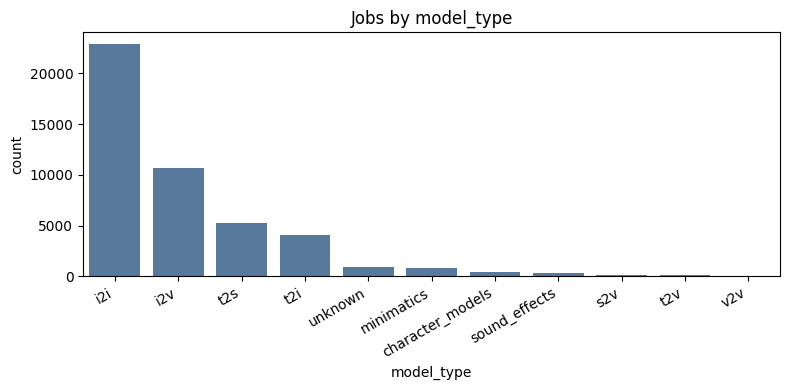

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of counts by model_type
counts = df['model_type'].fillna('unknown').value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=counts.index, y=counts.values, color="#4C78A8")
ax.set_title("Jobs by model_type")
ax.set_xlabel("model_type")
ax.set_ylabel("count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()


Variables that feel to some extent important


- resultDownloadedAt --> good proxy to capture if they output was good

In [ ]:
df[df['model_type'] == 'unknown']['modelConfig.id'].value_counts().head(20)

modelConfig.id
fluxKontextPro           807
google/nano-banana       708
soundEffectElevenLabs    559
Fahco4VZzobUeiPqni1S     545
fluxschnell              523
mmC3q9a9xRiR1m1UBHbj     460
imagegen4fast            394
ptBd2v6mebIps3ZQEXD7     312
jXuksIgonIKWaPC8gdwP     299
startEndToVideoKling     250
rdDUoCO1RjwdMmNjmhHV     225
dG7SBJDxDoZkQUrwvqrD     181
1TE7ou3jyxHsyRehUuMB     180
7Ren0A2JmdY0SeJTRLy4     177
fluxDev                  172
pUc0ICJmfLt4tXNq3KNb     139
s2vPixverseLipsync       121
aAbVdJPWb3aJZA1ax31H     110
b6UtgdzviyF3kdUzNIlT      97
exsUS4vynmxd379XN4yO      96
Name: count, dtype: int64

In [ ]:
df.head()

_id                                 jobId  \
0  67a49e93b2506bebffb39f01  84590c78-181b-4c75-aaa2-637b11f7f623   
1  67ac3503f9173eb4750d1792  f221bb6b-9dea-4915-901d-72a6f86ae6d1   
2  67ad88bd733296fc61bfc399  de16cba3-6c98-4344-b337-f0ce195f4097   
3  67b07f13733296fc61bffbc1  c46e8ac8-0055-488d-8547-f45607e76576   
4  67b2ecf8733296fc61c020ef  e7d9ab09-16cd-4262-afb6-6b07704c2eb5   

                                 userId               createdAt     status  \
0  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-06 11:35:45.368  completed   
1  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-12 05:43:30.148  completed   
2  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-13 05:52:59.519  cancelled   
3  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-15 11:48:34.880  completed   
4  de4b6003-2c85-49d0-bde5-b3b28dd9c1f4 2025-02-17 08:02:00.548  completed   

                updatedAt      modelConfig.name  \
0 2025-02-06 11:37:28.469  Character Generation   
1 2025-02-12 05:44:44.954  Character Generation   
2 2025-02-13 05:54:28.376        Model Training   
3 2025-02-15 11:50:52.971  Character Generation   
4 2025-02-17 08:06:05.378        Image to Video   

                                      modelConfig.id modelConfig.outputType  \
0  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
1  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
2  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
3  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
4                                           i2vKling                  VIDEO   

  modelConfig.modelType modelConfig.provider  modelConfig.pollingIntervalMs  \
0           CONTROL_NET            REPLICATE                           5000   
1           CONTROL_NET            REPLICATE                           5000   
2           CONTROL_NET            REPLICATE                           5000   
3           CONTROL_NET            REPLICATE                           5000   
4             ASSET_GEN            REPLICATE                           5000   

   modelConfig.noOfGenerations  \
0                          3.0   
1                          3.0   
2                          3.0   
3                          3.0   
4                          NaN   

                                  modelConfig.inputs  \
0  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
1  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
2  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
3  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
4  [{'id': 'start_image', 'label': 'Image', 'type...   

                                  outputLinks.cancel  \
0  https://api.replicate.com/v1/predictions/243j5...   
1  https://api.replicate.com/v1/predictions/qx6cn...   
2  https://api.replicate.com/v1/predictions/2vx6d...   
3  https://api.replicate.com/v1/predictions/bxnek...   
4  https://api.replicate.com/v1/predictions/m7rqz...   

                                    outputLinks.poll  \
0  https://api.replicate.com/v1/predictions/243j5...   
1  https://api.replicate.com/v1/predictions/qx6cn...   
2  https://api.replicate.com/v1/predictions/2vx6d...   
3  https://api.replicate.com/v1/predictions/bxnek...   
4  https://api.replicate.com/v1/predictions/m7rqz...   

                                  outputLinks.stream  \
0  https://stream.replicate.com/v1/files/bcwr-m6m...   
1  https://stream.replicate.com/v1/files/bcwr-y3k...   
2  https://stream.replicate.com/v1/files/bcwr-ori...   
3  https://stream.replicate.com/v1/files/bcwr-d7q...   
4  https://stream.replicate.com/v1/files/bcwr-pv6...   

                                  outputLinks.result  \
0  https://renderboard-test.s3.us-east-005.backbl...   
1  https://renderboard-test.s3.us-east-005.backbl...   
2                                                      
3  https://renderboard-test.s3.us-east-005.backbl...   
4  https://renderboard-test.s3.us-east-005.backbl.

In [ ]:
df[df['model_type'] == 'unknown']

_id                                 jobId  \
0      67a49e93b2506bebffb39f01  84590c78-181b-4c75-aaa2-637b11f7f623   
1      67ac3503f9173eb4750d1792  f221bb6b-9dea-4915-901d-72a6f86ae6d1   
2      67ad88bd733296fc61bfc399  de16cba3-6c98-4344-b337-f0ce195f4097   
3      67b07f13733296fc61bffbc1  c46e8ac8-0055-488d-8547-f45607e76576   
10     67b397bb733296fc61c02ae0  15dc46dd-f59f-49f0-8b35-15309720c358   
...                         ...                                   ...   
45321  698f575e785a26f04de65920  c478e8b9-6ba3-4cea-9ab0-f4b38fa661f5   
45330  6992aaa27d0938239214d7bb  db526efb-017c-45b4-8aef-21d02cc2fa9b   
45331  6992aabe7d0938239214d7bd  103685b9-dcc1-4913-a5a4-6f53341f10f1   
45459  6992ffa37d0938239214ff96  358398b3-9f56-4cfb-85dd-a3e2b9e2aae4   
45460  6992ffc27d0938239214ff99  d8a7f8aa-9625-43dd-9747-7d7a9968d254   

                                     userId               createdAt  \
0      76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-06 11:35:45.368   
1      76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-12 05:43:30.148   
2      76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-13 05:52:59.519   
3      76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-15 11:48:34.880   
10     76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-17 20:10:35.841   
...                                     ...                     ...   
45321  ea4aabc6-51da-45fe-b6a2-bc5f784c235a 2026-02-13 16:54:54.880   
45330  1d9f4833-4b63-474a-b98c-aa1f9160f3f5 2026-02-16 05:26:58.191   
45331  1d9f4833-4b63-474a-b98c-aa1f9160f3f5 2026-02-16 05:27:26.328   
45459  5488779e-4a23-4c8c-adbc-b740c1984fae 2026-02-16 11:29:38.935   
45460  5488779e-4a23-4c8c-adbc-b740c1984fae 2026-02-16 11:30:10.532   

          status               updatedAt      modelConfig.name  \
0      completed 2025-02-06 11:37:28.469  Character Generation   
1      completed 2025-02-12 05:44:44.954  Character Generation   
2      cancelled 2025-02-13 05:54:28.376        Model Training   
3      completed 2025-02-15 11:50:52.971  Character Generation   
10     cancelled 2025-02-18 08:25:50.269        Model Training   
...          ...                     ...                   ...   
45321  completed 2026-02-13 16:55:01.466        Text to Speech   
45330  completed 2026-02-16 05:27:09.194         Meta MusicGen   
45331  completed 2026-02-16 05:27:40.479         Meta MusicGen   
45459  completed 2026-02-16 11:29:38.935        Text to Speech   
45460  completed 2026-02-16 11:30:10.532        Text to Speech   

                                          modelConfig.id  \
0      lucataco/controlnet-union-pro:bd0dacc60e6247a2...   
1      lucataco/controlnet-union-pro:bd0dacc60e6247a2...   
2      lucataco/controlnet-union-pro:bd0dacc60e6247a2...   
3      lucataco/controlnet-union-pro:bd0dacc60e6247a2...   
10                         fluxdev/flux-dev-lora-trainer   
...                                                  ...   
45321                               ptBd2v6mebIps3ZQEXD7   
45330  meta/musicgen:671ac645ce5e552cc63a54a2bbff63fc...   
45331  meta/musicgen:671ac645ce5e552cc63a54a2bbff63fc...   
45459                               GOUZ9MgPPqx6acDGgVcc   
45460                               FRfdn2bl8gsmZWAFLsRr   

      modelConfig.outputType modelConfig.modelType  \
0                CONTROL_NET           CONTROL_NET   
1                CONTROL_NET           CONTROL_NET   
2                CONTROL_NET           CONTROL_NET   
3                CONTROL_NET           CONTROL_NET   
10             TRAINED_MODEL              TRAINING   
...                      ...                   ...   
45321                  AUDIO                   TTS   
45330                  AUDIO             MUSIC_GEN   
45331                  AUDIO             MUSIC_GEN   
45459                  AUDIO                   TTS   
45460                  AUDIO                   TTS   

                    modelConfig.provider  modelConfig.pollingIntervalMs  \
0                              REPLICATE                    

In [ ]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
df.sample(3).T

37381  \
_id                                                                        6964900c79df01c2309e51c8   
jobId                                                          e3192972-775c-4272-97a1-b7d1bd4db476   
userId                                                         bec7368e-845a-4075-acbb-557249937bb5   
createdAt                                                                2026-01-12 06:09:16.720000   
status                                                                                    completed   
updatedAt                                                                2026-01-12 06:12:01.696000   
modelConfig.name                                                                     Image to Image   
modelConfig.id                                                                    i2i-nanoBananaPro   
modelConfig.outputType                                                                        IMAGE   
modelConfig.modelType                                                                     IMAGE_GEN   
modelConfig.provider                                                                      REPLICATE   
modelConfig.pollingIntervalMs                                                                  5000   
modelConfig.noOfGenerations                                                                     3.0   
modelConfig.inputs                                [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
outputLinks.cancel                                https://api.replicate.com/v1/predictions/1whxy...   
outputLinks.poll                                  https://api.replicate.com/v1/predictions/1whxy...   
outputLinks.stream                                https://stream.replicate.com/v1/files/jbxs-dqj...   
outputLinks.result                                https://renderboard-test.s3.us-east-005.backbl...   
modelConfig.modelTitle                                                    Replicate Nano Banana Pro   
jobMetaData.traits                                                                              NaN   
jobMetaData.artStyle                                                                            NaN   
jobMetaData.characterName                                                                       NaN   
error.code                                                                                      NaN   
error.message                                                                                   NaN   
error.details.timestamp                                                                         NaN   
jobMetaData.controlNetConfigId                                                                  NaN   
modelConfig.modelMetaData.replicatePredictionURL  https://api.replicate.com/v1/models/google/nan...   
jobMetaData.destinationModelName                                                                NaN   
error.details.modelId                                                                           NaN   
modelMetaData.traits                                                                            NaN   
modelMetaData.artStyle                                                                          NaN   
modelMetaData.characterName                                                                     NaN   
assetId                                                                                         NaN   
modelConfig.modelMetaData.waitForCompletion                                                     NaN   
jobFeedback.isLiked                                                                             NaN   
jobMetaData.triggerWord                                                                         NaN   
jobMetaData.b2ZipUrl                                                                            NaN   
modelConfig.modelMetaData.viduPredictionURL                                                     NaN   
jobMetaData.jobBatchId                                         4348590b-bea0-

resultDownloadedAt	

In [ ]:
# query = {}
# model_ids=["I2V", "T2V"]
# query["modelConfig.id"] = {"$in": model_ids}

In [ ]:
# BASE_PROJECTION = {
#     "_id": 1,
#     "jobId": 1,
#     "createdAt": 1,
#     "updatedAt": 1,
#     "status": 1,
#     "userId": 1,
#     "modelConfig.id": 1,
#     "modelConfig.name": 1,
#     "modelConfig.provider": 1,
#     "error.code": 1,
#     "error.message": 1,
# }


In [ ]:
# df = pd.json_normalize(COLLECTION.find(
#         query,
#         BASE_PROJECTION
#     ))

In [ ]:
df.head()

_id                                 jobId  \
0  67a49e93b2506bebffb39f01  84590c78-181b-4c75-aaa2-637b11f7f623   
1  67ac3503f9173eb4750d1792  f221bb6b-9dea-4915-901d-72a6f86ae6d1   
2  67ad88bd733296fc61bfc399  de16cba3-6c98-4344-b337-f0ce195f4097   
3  67b07f13733296fc61bffbc1  c46e8ac8-0055-488d-8547-f45607e76576   
4  67b2ecf8733296fc61c020ef  e7d9ab09-16cd-4262-afb6-6b07704c2eb5   

                                 userId               createdAt     status  \
0  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-06 11:35:45.368  completed   
1  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-12 05:43:30.148  completed   
2  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-13 05:52:59.519  cancelled   
3  76de864a-c6da-4189-bcb0-2dc5e4dc08e0 2025-02-15 11:48:34.880  completed   
4  de4b6003-2c85-49d0-bde5-b3b28dd9c1f4 2025-02-17 08:02:00.548  completed   

                updatedAt      modelConfig.name  \
0 2025-02-06 11:37:28.469  Character Generation   
1 2025-02-12 05:44:44.954  Character Generation   
2 2025-02-13 05:54:28.376        Model Training   
3 2025-02-15 11:50:52.971  Character Generation   
4 2025-02-17 08:06:05.378        Image to Video   

                                      modelConfig.id modelConfig.outputType  \
0  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
1  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
2  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
3  lucataco/controlnet-union-pro:bd0dacc60e6247a2...            CONTROL_NET   
4                                           i2vKling                  VIDEO   

  modelConfig.modelType modelConfig.provider  modelConfig.pollingIntervalMs  \
0           CONTROL_NET            REPLICATE                           5000   
1           CONTROL_NET            REPLICATE                           5000   
2           CONTROL_NET            REPLICATE                           5000   
3           CONTROL_NET            REPLICATE                           5000   
4             ASSET_GEN            REPLICATE                           5000   

   modelConfig.noOfGenerations  \
0                          3.0   
1                          3.0   
2                          3.0   
3                          3.0   
4                          NaN   

                                  modelConfig.inputs  \
0  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
1  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
2  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
3  [{'id': 'prompt', 'label': 'Prompt', 'type': '...   
4  [{'id': 'start_image', 'label': 'Image', 'type...   

                                  outputLinks.cancel  \
0  https://api.replicate.com/v1/predictions/243j5...   
1  https://api.replicate.com/v1/predictions/qx6cn...   
2  https://api.replicate.com/v1/predictions/2vx6d...   
3  https://api.replicate.com/v1/predictions/bxnek...   
4  https://api.replicate.com/v1/predictions/m7rqz...   

                                    outputLinks.poll  \
0  https://api.replicate.com/v1/predictions/243j5...   
1  https://api.replicate.com/v1/predictions/qx6cn...   
2  https://api.replicate.com/v1/predictions/2vx6d...   
3  https://api.replicate.com/v1/predictions/bxnek...   
4  https://api.replicate.com/v1/predictions/m7rqz...   

                                  outputLinks.stream  \
0  https://stream.replicate.com/v1/files/bcwr-m6m...   
1  https://stream.replicate.com/v1/files/bcwr-y3k...   
2  https://stream.replicate.com/v1/files/bcwr-ori...   
3  https://stream.replicate.com/v1/files/bcwr-d7q...   
4  https://stream.replicate.com/v1/files/bcwr-pv6...   

                                  outputLinks.result  \
0  https://renderboard-test.s3.us-east-005.backbl...   
1  https://renderboard-test.s3.us-east-005.backbl...   
2                                                      
3  https://renderboard-test.s3.us-east-005.backbl...   
4  https://renderboard-test.s3.us-east-005.backbl.

In [ ]:
##This job id I did t2i I asked for and image of a Create me a photo of a kid aged 10 years, that lives in the Swedsh countryside in 1850 in a farm. He's dirty, wears a cap
df[df['jobId'] == '94901d12-09f3-4716-8cf7-9bf92461bd22'].T

43232
_id                                                                        6989aee5785a26f04de215ff
jobId                                                          94901d12-09f3-4716-8cf7-9bf92461bd22
userId                                                         9d185f86-8c38-400d-8da1-6e833396cfed
createdAt                                                                2026-02-09 09:54:45.610000
status                                                                                    completed
updatedAt                                                                2026-02-09 09:56:20.574000
modelConfig.name                                                                      Text to Image
modelConfig.id                                                                       t2i-nanoBanana
modelConfig.outputType                                                                        IMAGE
modelConfig.modelType                                                                     IMAGE_GEN
modelConfig.provider                                                                      REPLICATE
modelConfig.pollingIntervalMs                                                                  5000
modelConfig.noOfGenerations                                                                     3.0
modelConfig.inputs                                [{'id': 'prompt', 'label': 'Prompt', 'type': '...
outputLinks.cancel                                https://api.replicate.com/v1/predictions/t5m1a...
outputLinks.poll                                  https://api.replicate.com/v1/predictions/t5m1a...
outputLinks.stream                                https://stream.replicate.com/v1/files/jbxs-iiy...
outputLinks.result                                https://renderboard-test.s3.us-east-005.backbl...
modelConfig.modelTitle                                                                  Nano Banana
jobMetaData.traits                                                                              NaN
jobMetaData.artStyle                                                                            NaN
jobMetaData.characterName                                                                       NaN
error.code                                                                                      NaN
error.message                                                                                   NaN
error.details.timestamp                                                                         NaN
jobMetaData.controlNetConfigId                                                                  NaN
modelConfig.modelMetaData.replicatePredictionURL  https://api.replicate.com/v1/models/google/nan...
jobMetaData.destinationModelName                                                                NaN
error.details.modelId                                                                           NaN
modelMetaData.traits                                                                            NaN
modelMetaData.artStyle                                                                          NaN
modelMetaData.characterName                                                                     NaN
assetId                                                                                         NaN
modelConfig.modelMetaData.waitForCompletion                                                     NaN
jobFeedback.isLiked                                                                             NaN
jobMetaData.triggerWord                                                                         NaN
jobMetaData.b2ZipUrl                                                                            NaN
modelConfig.modelMetaData.viduPredictionURL                                                     NaN
jobMetaData.jobBatchId                                         80cfe738-e88c-4a23-ab84-9ca73ba99d79
modelConfig.modelLabels                                                                       

In [ ]:
# This prompt I asked for i2i. So a border collied to be added next to the kid in the previous image
df[df['jobId'] == '296595e6-882e-4441-87c4-2596f619c9ba'].T

43288
_id                                                                        6989b90c785a26f04de216a2
jobId                                                          296595e6-882e-4441-87c4-2596f619c9ba
userId                                                         9d185f86-8c38-400d-8da1-6e833396cfed
createdAt                                                                2026-02-09 10:38:04.394000
status                                                                                    completed
updatedAt                                                                2026-02-09 10:38:46.056000
modelConfig.name                                                                     Image to Image
modelConfig.id                                                                       i2i-nanoBanana
modelConfig.outputType                                                                        IMAGE
modelConfig.modelType                                                                     IMAGE_GEN
modelConfig.provider                                                                      REPLICATE
modelConfig.pollingIntervalMs                                                                  5000
modelConfig.noOfGenerations                                                                     3.0
modelConfig.inputs                                [{'id': 'prompt', 'label': 'Prompt', 'type': '...
outputLinks.cancel                                https://api.replicate.com/v1/predictions/pfgq5...
outputLinks.poll                                  https://api.replicate.com/v1/predictions/pfgq5...
outputLinks.stream                                https://stream.replicate.com/v1/files/jbxs-mjw...
outputLinks.result                                https://renderboard-test.s3.us-east-005.backbl...
modelConfig.modelTitle                                                                  Nano Banana
jobMetaData.traits                                                                              NaN
jobMetaData.artStyle                                                                            NaN
jobMetaData.characterName                                                                       NaN
error.code                                                                                      NaN
error.message                                                                                   NaN
error.details.timestamp                                                                         NaN
jobMetaData.controlNetConfigId                                                                  NaN
modelConfig.modelMetaData.replicatePredictionURL  https://api.replicate.com/v1/models/google/nan...
jobMetaData.destinationModelName                                                                NaN
error.details.modelId                                                                           NaN
modelMetaData.traits                                                                            NaN
modelMetaData.artStyle                                                                          NaN
modelMetaData.characterName                                                                     NaN
assetId                                                                                         NaN
modelConfig.modelMetaData.waitForCompletion                                                     NaN
jobFeedback.isLiked                                                                             NaN
jobMetaData.triggerWord                                                                         NaN
jobMetaData.b2ZipUrl                                                                            NaN
modelConfig.modelMetaData.viduPredictionURL                                                     NaN
jobMetaData.jobBatchId                                         88a5bd35-75a6-4d41-8fb2-1fd5c4fbc83d
modelConfig.modelLabels                                                                       

In [ ]:
# Display all values of modelConfig.inputs for this job id
df[df['jobId'] == '296595e6-882e-4441-87c4-2596f619c9ba']['modelConfig.inputs'].values[0]

[{'id': 'prompt',
  'label': 'Prompt',
  'type': 'TEXT',
  'isRequired': True,
  'value': 'can you add a dog next to the kid. Make it a border collie '},
 {'id': 'image_input',
  'label': 'Input Image',
  'type': 'MULTIPLE_IMAGE',
  'isRequired': True,
  'maxInputLength': 14,
  'value': ['https://renderboard-test.s3.us-east-005.backblazeb2.com/images/base64-1e1aa774-6918-4bb4-baea-fa3c6b3a31e0.png']},
 {'id': 'aspect_ratio',
  'label': 'Aspect Ratio',
  'type': 'SELECT',
  'isRequired': True,
  'defaultValue': 'match_input_image',
  'value': '3:2',
  'selectOptions': [{'label': 'Auto', 'value': 'match_input_image'},
   {'label': '1:1', 'value': '1:1'},
   {'label': '2:3', 'value': '2:3'},
   {'label': '3:2', 'value': '3:2'},
   {'label': '3:4', 'value': '3:4'},
   {'label': '4:3', 'value': '4:3'},
   {'label': '4:5', 'value': '4:5'},
   {'label': '5:4', 'value': '5:4'},
   {'label': '9:16', 'value': '9:16'},
   {'label': '16:9', 'value': '16:9'},
   {'label': '21:9', 'value': '21:9'}]}